In [2]:
'''
increasing exposure time to account for photon noise

need to set up env variable before running notebook

terminal command: export PYSYN_CDBS = /Users/tchawla/research/HST_data/grp/redcat/trds
or: point towards correct directory. var name mys be PYSYN_CDBS

running other notebooks here so I can access their written functions
'''

import numpy as np
from astropy.io import ascii
from pylab import *
from astropy.table import Table, vstack
import pandas as pd
from expecto import get_spectrum
from scipy.interpolate import RegularGridInterpolator as rgi
from scipy.stats import binned_statistic as bin
from itertools import product
%run Interpolate_final_v2.ipynb
%run GetSpectra_final_v2.ipynb
%run Binning_final_v2.ipynb
%run AddNoise_final_v2.ipynb
%run Model.ipynb
import batman

/opt/anaconda3/lib/python3.8/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in /Users/angelachawla/Documents/research/pwv_noise_removal/Data/HST_data/grp/redcat/trds/extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


In [3]:
water_array = [1.0, 1.5, 2.5, 3.5, 5.0]

'''
reads in .dat files. col1 is wavelength, col2 is transmission. Files are labeled with water content level in mm 
water content levels are listed in the array above. resolution is 200,000.
'''

d = {}
i=0
for n in water_array:
    water_content = str(water_array[i])
    d["data"+water_content] = ascii.read("../Data/transmission{0}_hi_res.dat".format(water_content))
    d["data"+water_content+"_pd"] = d["data"+water_content].to_pandas()
    #print(d["data"+water_content+"_pd"])
    i+=1

In [4]:
'''
for loop creates transmission values in shape necessary for interpolation function
'''
water_array = [1.0, 1.5, 2.5, 3.5, 5.0]

flux_array = []
i=0
for n in water_array:
    water_array_i = str(water_array[i])
    d["flux"+water_array_i] = np.array(d["data"+water_array_i+"_pd"]["col2"])
    flux_array.append(d["flux"+water_array_i])
    i+=1

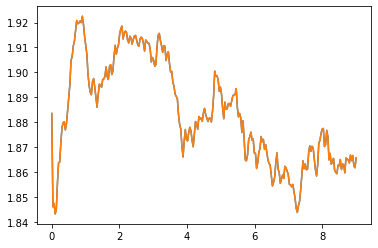

In [5]:
'''
setting angular separation values for pwv timeseries. Separation parameter at the ent of t1 line. 
Here, separation is 0, testing effect of second order exinction

Covers 9 hours (270 points, each point is two minutes)
'''


timestamps = np.linspace(0,9,270) 
t, target_star_pwv, target_star_phase, target_star_mean = power_spectrum(12000, 1, 24000, timestamps, mean = 2)
t1, comparison_star_pwv, _, _ = power_spectrum(12000, 1, 24000, timestamps, mean = target_star_mean, target = False, phase = target_star_phase, separation = 0)

plt.plot(t, target_star_pwv)
plt.plot(t, comparison_star_pwv)
plt.show()


In [6]:
'''
Reading in transit data for three planets. Starting with hot jupiter in this notebook
'''


water_world_abs1 = ascii.read("../Data/water_world_abs1.dat")
water_world_abs2 = ascii.read("../Data/water_world_abs2.dat")
water_world_abs3 = ascii.read("../Data/water_world_abs3.dat")
water_world_abs4 = ascii.read("../Data/water_world_abs4.dat")

hot_jupiter_abs1 = ascii.read("../Data/hot_jupiter_abs1.dat")
hot_jupiter_abs2 = ascii.read("../Data/hot_jupiter_abs2.dat")
hot_jupiter_abs3 = ascii.read("../Data/hot_jupiter_abs3.dat")
hot_jupiter_abs4 = ascii.read("../Data/hot_jupiter_abs4.dat")

warm_jupiter_abs1 = ascii.read("../Data/warm_jupiter_abs1.dat")
warm_jupiter_abs2 = ascii.read("../Data/warm_jupiter_abs2.dat")
warm_jupiter_abs3 = ascii.read("../Data/warm_jupiter_abs3.dat")
warm_jupiter_abs4 = ascii.read("../Data/warm_jupiter_abs4.dat")

In [7]:
'''
wave ranges will let us compare index to wavelength for each abs chunk

ex: hot_jupiter_abs1[20] will have wavelength wave_range_abs1[20]
'''

wave_range_abs1 = bin_array(.6, 1, 200)
wave_range_abs2 = bin_array(1, 1.25, 200)
wave_range_abs3 = bin_array(1.25, 1.56, 200)
wave_range_abs4 = bin_array(1.56, 2.1, 200)

In [8]:
'''
batman transit parameters. Using real rp and period
'''

params_hot_jupiter = batman.TransitParams()       #object to store transit parameters
params_hot_jupiter.t0 = 0.                        #time of inferior conjunction
params_hot_jupiter.per = 4.7361                       #orbital period 

# assume rp of .07 for now
params_hot_jupiter.rp = 0.04644                       #planet radi`us (in units of stellar radii)
#at each wavelength, add transit depth for atm. Will alter rp parameter
#change in atm depth in ppm
#Depth is rp^2 (because it's in units of solar radii)
#As such, rp is sqrt of depth



params_hot_jupiter.a = 4.98                        #semi-major axis (in units of stellar radii)
params_hot_jupiter.inc = 90                      #orbital inclination (in degrees)
params_hot_jupiter.ecc = 0.                       #eccentricity
params_hot_jupiter.w = 90.                        #longitude of periastron (in degrees)
params_hot_jupiter.limb_dark = "linear"        #limb darkening model
params_hot_jupiter.u = [0.5]      #limb darkening coefficients [u1, u2, u3, u4]

t = np.linspace(-0.5, 0.5, 270)  #times at which to calculate light curve
model_hot_jupiter = batman.TransitModel(params_hot_jupiter, t)    #initializes model

Text(0.5, 0, 'Phase')

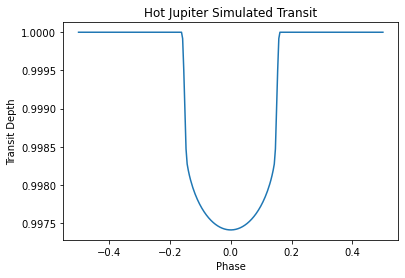

In [9]:
'''
plotted simulated transit, non-wavelength dependent
'''
transit = model_hot_jupiter.light_curve(params_hot_jupiter)
plt.plot(t, transit)

plt.title("Hot Jupiter Simulated Transit")
plt.ylabel("Transit Depth")
plt.xlabel("Phase")

#plt.savefig("transit.png")

In [10]:
'''
mag 4 stars in oct 26 file. here, running with mag 7
'''

target_spec = np.load("../Data/target_T4000_mag7.npy")
ref_spec_3000 = np.load("../Data/ref_T3000_mag7.npy")
ref_spec_5000 = np.load("../Data/ref_T5000_mag7.npy")
ref_spec_7000 = np.load("../Data/ref_T7000_mag7.npy")

In [11]:
'''
loading in divided and binned spectra and timeseries instead of generating it every time. 
This data is for 4000K target and 3000K ref, 4 mag with 0 ang sep'''
'''
divided_hot_jupiter_abs1 = np.load("../Data/0_ang_sep/binned_hotjupiter_abs1.npy")
divided_hot_jupiter_abs2 = np.load("../Data/0_ang_sep/binned_hotjupiter_abs2.npy")
divided_hot_jupiter_abs3 = np.load("../Data/0_ang_sep/binned_hotjupiter_abs3.npy")
divided_hot_jupiter_abs4 = np.load("../Data/0_ang_sep/binned_hotjupiter_abs4.npy")
'''


'\ndivided_hot_jupiter_abs1 = np.load("../Data/0_ang_sep/binned_hotjupiter_abs1.npy")\ndivided_hot_jupiter_abs2 = np.load("../Data/0_ang_sep/binned_hotjupiter_abs2.npy")\ndivided_hot_jupiter_abs3 = np.load("../Data/0_ang_sep/binned_hotjupiter_abs3.npy")\ndivided_hot_jupiter_abs4 = np.load("../Data/0_ang_sep/binned_hotjupiter_abs4.npy")\n'

In [12]:
'''
Increasing exposure time
'''
'''
calculates photon noise, normalized to 0. throughput and transmission are fractional values. Transmission is set up to be
calculated over array of water content values (for pwv timeseries). 

Questions: how do we get initial photon count from the star from the flux? In practice I think we could get that value
directly from Henrietta's CCD detectors, but how do we do it simulation?

I guess if it's normalized, it's really calculting a percentage value and not actual changes in flux, and any flux values
could be used.

What units for exposure time? (pwv time series, each point is 1 minute) (needs to compare to flux, meausured in photons/sec)

re-write in terms of gaussian

after re-writing: I'm getting significantly different values from the gaussian and poisson distributions. It seems like 
poisson dist has much (orders of mag) larger std dev. Maybe I'm using the np version of the random generator wrong?
I thought poisson std dev was supposed to decrease with point count, but it still seems large even with values of 10**14

missing bin size, should be low resolution bin size

Note: right now, bin sizes are in angstroms, since this is the unit that the hi-res flux comes with. Bin sizes are filtered
from binning function to stacking to division_noise to photon_noise. bin sizes for 1.8-1.95 microns are about 180-190 A. 
'''

def photon_noise(flux, bin_size, mirror_diameter = 100, exp_time = 120, throughput = .4):
    
    mirror_area = np.pi*((mirror_diameter/2)**2) - np.pi*((25)**2)
    #print("mirror area:"+str(mirror_area))
    
    #bin_size_array = [bin_array[1]-bin_array[0]]
    '''
    i=0
    for n in bin_array:
        if i == len(bin_array)-1:
            break
        bin_size2 = bin_array[i+1] - bin_array[i]
        bin_size_array.append(bin_size2)
        j+=1
    '''
    num_photons = flux*mirror_area*exp_time*throughput*bin_size
    #print("num photons:"+str(num_photons[0:10]))
    noise_std_dev = 1/(num_photons**(1/2))
    #print("noise std dev: "+str(noise_std_dev))
    
    photon_noise_gaussian = np.random.normal(1, noise_std_dev, len(flux))
    
    return photon_noise_gaussian


'''
throughput of 0.4, swope is 1m in diameter, hole is .5m in diameter
'''


'\nthroughput of 0.4, swope is 1m in diameter, hole is .5m in diameter\n'

In [13]:

def bin_divide(target_spec, ref_spec, target_pwv, ref_pwv, wave_in, wave_out, atm, rp, res=200):
    target_binned = binned_flux_pwv_v2(target_spec, target_pwv, wave_in, wave_out, res)
    #wave_array = target_binned_all[1]
    ref_binned = binned_flux_pwv_v2(ref_spec, ref_pwv, wave_in, wave_out, res)
    target_stacked = stacking(target_binned)
    ref_stacked = stacking(ref_binned)
    diff = division_noise_transit(target_stacked, ref_stacked, atm, rp)
    return diff


In [14]:
def division_noise_transit(target_array, ref_array, atm, params):
    new_array1 = []
    bin_size_array = [target_array[1][1]-target_array[1][0]]
    
    t = np.linspace(-0.5, 0.5, 270)
    #print("right function!")
    bulk_transit_depth = params.rp**2
    print("bulk_transit_depth: "+str(bulk_transit_depth))
    print("bulk_rp: "+str(params.rp))
    #new_array2
    i=0
    for n in target_array[0][0]:
        if i >= len(atm["col5"]):
            break
        
        bin_size = target_array[1][i+1]-target_array[1][i]
        #print("bin size: "+str(bin_size))
        bin_size_array.append(bin_size)
        target_array_i = np.array(target_array[0][:,i])
        #print(target_array_i[50:60])
        #print("original target array"+str(target_array_i[0:10]))
        
        #adding transit
        atm_transit_i = atm["col5"][i]/10**6
        #print("atm transit: "+ str(atm_transit_i))
        #print("atm depth"+str(atm_transit_i))
        
        total_transit_depth = bulk_transit_depth + atm_transit_i
        #print("total transit depth: "+ str(total_transit_depth))
        rp_i = np.sqrt(total_transit_depth)
        #print("rp i : "+ str(rp_i))
        params.rp = rp_i
        #print("edited param : "+ str(params.rp))
        #print("rp"+str(params.rp))
        model = batman.TransitModel(params, t)
        transit = model.light_curve(params)
        #print("transit model"+str(transit[500:510]))
        plt.plot(transit)
        
        #flux = stellar_flux_value*transmission
        #print("transit length " + str(len(transit)))
        #print("target array length " + str(len(target_array_i)))
        transit_flux = transit*target_array_i

        #plt.plot(transit_flux)
        #print("flux with transit"+str(transit_flux[0:10]))
        
        
        ref_array_i = np.array(ref_array[0][:,i])
        #print(ref_array_i[50:60])
        target_noise = photon_noise(transit_flux, bin_size)
        #print("target_noise: "+str(target_noise))
        ref_noise = photon_noise(ref_array_i, bin_size)
        #print("ref_noise: "+str(ref_noise))
        noisy_target_i = target_noise*transit_flux
        #plt.plot(noisy_target_i)
        #print("target_noisy flux: "+str(noisy_target_i))
        noisy_ref_i = ref_noise*ref_array_i
        #print("ref_noisy flux: "+str(noisy_ref_i))
        divided_i = noisy_target_i/noisy_ref_i
        #plt.plot(divided_i)
        #print("div_noisy flux: "+str(divided_i))
        new_array1.append(divided_i)
        i+=1
        #if i == 3:
            #break
    return new_array1

#cold_star_abs1_test3[:,0]


In [ ]:
def normalize(diff):
    '''
    target_spec = spectrum(target_temp, mag1)
    ref_spec = spectrum(ref_temp, mag2)
    
    target_binned = binned_flux_pwv_v2(target_spec, target_pwv, wave_in, wave_out, res)
    ref_binned = binned_flux_pwv_v2(ref_spec, ref_pwv, wave_in, wave_out, res)
    target_stacked = stacking(target_binned)
    ref_stacked = stacking(ref_binned)
    diff = division_noise(target_stacked, ref_stacked)
    
    #print(diff[0])
    '''
    normalized_array = []
    #photon_noise_array = 
    
    i=0
    for n in diff:
        '''
        input to photon noise needs to be actual flux value, not relative value after division. Needs to be multiplied into
        both target and ref fluxes?
        '''
        #photon_noise_i = photon_noise(diff[i], .5, exp_time, throughput)
        #print(photon_noise_i)
        #noisy_diff = diff[i]*photon_noise_i
        diff_mean = (np.mean(diff[i][0:75])+np.mean(diff[i][195:270]))/2
        normalized = (diff[i]-diff_mean)/diff_mean
        normalized_array.append(normalized)
        #j=0
        #for n in normalized:
            #photon_noise(normalized[j], .5, exp_time, throughput
        #print(diff_mean)
        i+=1
    #diff_mean = np.mean(diff)
    #normalized = (diff-diff_mean)/diff_mean
    
    
    return normalized_array

In [ ]:
def no_divide(target_spec, target_pwv, wave_in, wave_out, atm, rp, res=200):
    target_binned = binned_flux_pwv_v2(target_spec, target_pwv, wave_in, wave_out, res)
    target_stacked = stacking(target_binned)
    transit_added = noise_transit(target_stacked, atm, rp)
    return transit_added

In [ ]:
def noise_transit(target_array, atm, params):
    new_array1 = []
    bin_size_array = [target_array[1][1]-target_array[1][0]]
    
    t = np.linspace(-0.5, 0.5, 270)
    #print("right function!")
    bulk_transit_depth = params.rp**2
    print("bulk_transit_depth: "+str(bulk_transit_depth))
    print("bulk_rp: "+str(params.rp))
    #new_array2
    i=0
    for n in target_array[0][0]:
        if i >= len(atm["col5"]):
            break
        
        bin_size = target_array[1][i+1]-target_array[1][i]
        #print("bin size: "+str(bin_size))
        bin_size_array.append(bin_size)
        target_array_i = np.array(target_array[0][:,i])
        #print(target_array_i[50:60])
        #print("original target array"+str(target_array_i[0:10]))
        
        #adding transit
        atm_transit_i = atm["col5"][i]/10**6
        #print("atm transit: "+ str(atm_transit_i))
        #print("atm depth"+str(atm_transit_i))
        
        total_transit_depth = bulk_transit_depth + atm_transit_i
        #print("total transit depth: "+ str(total_transit_depth))
        rp_i = np.sqrt(total_transit_depth)
        #print("rp i : "+ str(rp_i))
        params.rp = rp_i
        #print("edited param : "+ str(params.rp))
        #print("rp"+str(params.rp))
        model = batman.TransitModel(params, t)
        transit = model.light_curve(params)
        #print("transit model"+str(transit[500:510]))
        plt.plot(transit)
        
        #flux = stellar_flux_value*transmission
        #print("transit length " + str(len(transit)))
        #print("target array length " + str(len(target_array_i)))
        transit_flux = transit*target_array_i

        #plt.plot(transit_flux)
        #print("flux with transit"+str(transit_flux[0:10]))
        
        '''
        ref_array_i = np.array(ref_array[0][:,i])
        #print(ref_array_i[50:60])
        '''
        target_noise = photon_noise(transit_flux, bin_size)
        #print("target_noise: "+str(target_noise))
        '''
        ref_noise = photon_noise(ref_array_i, bin_size)
        #print("ref_noise: "+str(ref_noise))
        '''
        noisy_target_i = target_noise*transit_flux
        #plt.plot(noisy_target_i)
        #print("target_noisy flux: "+str(noisy_target_i))
        '''
        noisy_ref_i = ref_noise*ref_array_i
        #print("ref_noisy flux: "+str(noisy_ref_i))
        divided_i = noisy_target_i/noisy_ref_i
        #plt.plot(divided_i)
        #print("div_noisy flux: "+str(divided_i))
        '''
        new_array1.append(noisy_target_i)
        i+=1
        #if i == 3:
            #break
    return new_array1

#cold_star_abs1_test3[:,0]


bulk_transit_depth: 0.0021566736
bulk_rp: 0.04644
bulk_transit_depth: 0.0021566736
bulk_rp: 0.04644
bulk_transit_depth: 0.0021566736
bulk_rp: 0.04644
bulk_transit_depth: 0.0021566736
bulk_rp: 0.04644


'\n#target_binned = binned_flux_pwv_v2(target_spec, target_star_pwv, .6, 1, 200)\n#ref_binned = binned_flux_pwv_v2(ref_spec, comparison_star_pwv, .6, 1, 200)\n\n#target_stacked = stacking(target_binned)\n#ref_stacked = stacking(ref_binned)\n\n\n#divided = division_noise_transit(target_stacked, ref_stacked, hot_jupiter_abs1, params_hot_jupiter)\n'

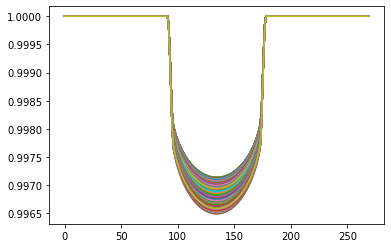

In [22]:
'''
Using target spec 4000K & ref spec 3000K

Binning is taking a really long time to run right now.

Output: binned and divided spectra with transit timeseries at each wavelength bin
'''


params_hot_jupiter.rp = 0.04644  
no_divide_abs1 = no_divide(target_spec, target_star_pwv, .6, 1, hot_jupiter_abs1, params_hot_jupiter)

params_hot_jupiter.rp = 0.04644
no_divide_abs2 = no_divide(target_spec, target_star_pwv, 1, 1.25, hot_jupiter_abs2, params_hot_jupiter)
params_hot_jupiter.rp = 0.04644
no_divide_abs3 = no_divide(target_spec, target_star_pwv, 1.25, 1.56, hot_jupiter_abs3, params_hot_jupiter)
params_hot_jupiter.rp = 0.04644
no_divide_abs4 = no_divide(target_spec, target_star_pwv, 1.56, 2.1, hot_jupiter_abs4, params_hot_jupiter)
'''
#target_binned = binned_flux_pwv_v2(target_spec, target_star_pwv, .6, 1, 200)
#ref_binned = binned_flux_pwv_v2(ref_spec, comparison_star_pwv, .6, 1, 200)

#target_stacked = stacking(target_binned)
#ref_stacked = stacking(ref_binned)


#divided = division_noise_transit(target_stacked, ref_stacked, hot_jupiter_abs1, params_hot_jupiter)
'''

In [23]:
'''
normalizing transit depth for each abs chunk
'''

normalized_hot_jupiter_abs1_3k = normalize(divided_hot_jupiter_abs1_3k)
normalized_hot_jupiter_abs2_3k = normalize(divided_hot_jupiter_abs2_3k)
normalized_hot_jupiter_abs3_3k = normalize(divided_hot_jupiter_abs3_3k)
normalized_hot_jupiter_abs4_3k = normalize(divided_hot_jupiter_abs4_3k)

In [24]:
'''
normalizing transit depth for each no div chunk
'''

normalized_nodiv_abs1 = normalize(no_divide_abs1)
normalized_nodiv_abs2 = normalize(no_divide_abs2)
normalized_nodiv_abs3 = normalize(no_divide_abs3)
normalized_nodiv_abs4 = normalize(no_divide_abs4)

1.3811194714834134


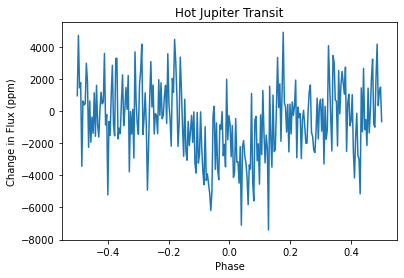

In [25]:
'''
Sample transit timeseries. Depth in ppm, normalized
'''

t = np.linspace(-0.5, 0.5, 270)


#plt.plot(t, normalized_hot_jupiter_abs4[40]*10**6, label="1.90 μm", color='#1f77b4')
plt.plot(t, normalized_hot_jupiter_abs3_3k[20]*10**6)
#plt.plot(t, normalized_hot_jupiter_abs1[87]*10**6, label=".93 μm", color="orange")



plt.title("Hot Jupiter Transit")
plt.xlabel("Phase")
plt.ylabel("Change in Flux (ppm)")

#plt.legend()
'''
label for wavelength. Should match index and waverange of transit timseries 
'''
print(str(wave_range_abs3[20]))

#plt.savefig("1.9and.93microns.png")
#plt.savefig("1.9microns.png")

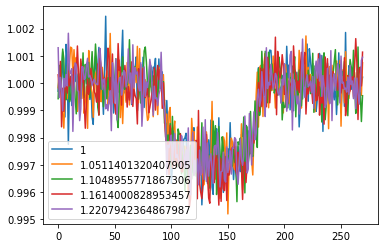

In [26]:
'''
normalized transit depths across wave range 2
'''

plt.plot(normalized_hot_jupiter_abs2_3k[0]+1, label=str(wave_range_abs2[0]))
#print(np.std(normalized_hot_jupiter_abs2[0][0:300]))
plt.plot(normalized_hot_jupiter_abs2_3k[10]+1, label=str(wave_range_abs2[10]))
plt.plot(normalized_hot_jupiter_abs2_3k[20]+1, label=str(wave_range_abs2[20]))
plt.plot(normalized_hot_jupiter_abs2_3k[30]+1, label=str(wave_range_abs2[30]))
plt.plot(normalized_hot_jupiter_abs2_3k[40]+1, label=str(wave_range_abs2[40]))

plt.legend()

0.0014065814518836115


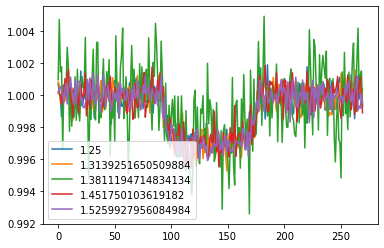

In [27]:
'''
normalized transit depths across wave range 3
'''

plt.plot(normalized_hot_jupiter_abs3_3k[0]+1, label=str(wave_range_abs3[0]))
print(np.std(normalized_hot_jupiter_abs3_3k[0][0:300]))
plt.plot(normalized_hot_jupiter_abs3_3k[10]+1, label=str(wave_range_abs3[10]))
plt.plot(normalized_hot_jupiter_abs3_3k[20]+1, label=str(wave_range_abs3[20]))
plt.plot(normalized_hot_jupiter_abs3_3k[30]+1, label=str(wave_range_abs3[30]))
plt.plot(normalized_hot_jupiter_abs3_3k[40]+1, label=str(wave_range_abs3[40]))

plt.legend()

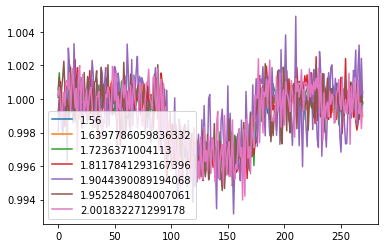

In [28]:
'''
normalized transit depths across wave range 4
'''

plt.plot(normalized_hot_jupiter_abs4_3k[0]+1, label=str(wave_range_abs4[0]))
plt.plot(normalized_hot_jupiter_abs4_3k[10]+1, label=str(wave_range_abs4[10]))
plt.plot(normalized_hot_jupiter_abs4_3k[20]+1, label=str(wave_range_abs4[20]))
plt.plot(normalized_hot_jupiter_abs4_3k[30]+1, label=str(wave_range_abs4[30]))
plt.plot(normalized_hot_jupiter_abs4_3k[40]+1, label=str(wave_range_abs4[40]))
plt.plot(normalized_hot_jupiter_abs4_3k[45]+1, label=str(wave_range_abs4[45]))
plt.plot(normalized_hot_jupiter_abs4_3k[50]+1, label=str(wave_range_abs4[50]))
#plt.plot(normalized_hot_jupiter_abs4[60]+1, label=str(wave_range_abs4[60]))

plt.legend()

In [29]:
'''
installed emcee, corner, will need to update pip soon

error got when I tried to pip install pytransit:
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
anaconda-project 0.9.1 requires ruamel-yaml, which is not installed.
conda-repo-cli 1.0.4 requires pathlib, which is not installed.
spyder 4.2.5 requires pyqt5<5.13, which is not installed.
spyder 4.2.5 requires pyqtwebengine<5.13, which is not installed.
anaconda-client 1.7.2 requires PyYAML>=3.12, but you have pyyaml 3.10 which is incompatible.
asdf 2.15.0 requires pyyaml>=5.4.1, but you have pyyaml 3.10 which is incompatible.
astropy 5.2.1 requires PyYAML>=3.13, but you have pyyaml 3.10 which is incompatible.
conda-repo-cli 1.0.4 requires PyYAML>=3.12, but you have pyyaml 3.10 which is incompatible.

emcee running ok now in Model.ipynb. This sets up corner plots for .81 and .99 microns
'''


%run Model.ipynb

#time = arange(1, 1001, 1)
times = np.linspace(-0.5, 0.5, 540)

#flux = normalized_hot_jupiter_abs1[0]
#transit

hotjupiter_81microns = normalized_hot_jupiter_abs1_3k[60]+1
hotjupiter_99microns = normalized_hot_jupiter_abs1_3k[100]+1

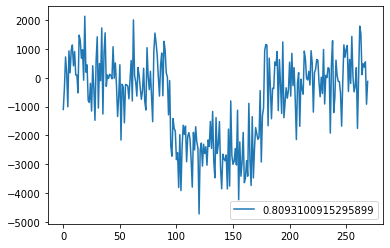

In [30]:
'''
testing transit depth visually at .81 microns
'''

plt.plot(normalized_hot_jupiter_abs1_3k[60]*1000000, label=str(wave_range_abs1[60]))
plt.legend()

In [31]:


class LPFunction:

    def __init__(self, name: str, times: np.ndarray = None, fluxes: np.ndarray = None, h_model: np.ndarray = np.array([])):

        self.tm = QuadraticModel(klims = (np.sqrt(.1), np.sqrt(.15)), nk = 512, nz = 512)


        # LPF name 
        # ________

        self.name = name

        # Declare high-level objects
        # __________________________

        self.ps = None          # Parameterization
        self.de = None          # Differential evolution optimizer
        self.sampler = None     # MCMC sampler


        # Initialize data
        # _______________

        self.times = np.asarray(times)
        self.fluxes = np.asarray(fluxes)
        #print(self.times)
        #print(times)
        #print(fluxes[0:10])
        #self.time_array = np.linspace(-0.5, 0.5, 1000)
        self.time_array = np.linspace(-0.5, 0.5, 270)
        self.tm.set_data(self.time_array)
        self.params = batman.TransitParams()
        self.params.t0 = 0
        self.params.per = 4.7361 
        self.params.rp = 0 
        self.params.a = 4.98
        self.params.ecc = 0
        self.params.w = 90
        self.params.inc = 90
        self.params.limb_dark = "linear"
        self.params.u = [0.5]
        self.m = batman.TransitModel(self.params, self.time_array, max_err = .02)
        # Define the parameterization
        # ___________________________

        self.ps = ParameterSet([GParameter('rp_rs', 'area_ratio',       'A_s',    UP(0.03, .2), bounds = (0.03, .2)),
                             GParameter('loge', 'log10_error',    '',       UP(-10,-2), bounds = (-10,-2))])
                                #sampling in log space, can do so uniformly

        
        self.ps.freeze()
        #plt.plot(self.time_array, fluxes)
        #plt.show()

        
    def create_pv_population(self, npop = 50):
        return self.ps.sample_from_prior(npop)

    def baseline(self, pv):
        return 1

    def transit_model(self, pv, copy = True):
        pv = np.atleast_2d(pv)
        model = []

        
        for parameter in pv:
            self.params.rp = parameter[0]
            
            model.append(self.m.light_curve(self.params))

        return np.array(model)
        


    def flux_model(self, pv):
        return self.transit_model(pv) * self.baseline(pv)

    def residuals(self, pv):
        return self.fluxes - self.flux_model(pv)

    
    def set_prior(self, pid: int, prior) -> None:
        self.ps[pid].prior = prior

    def lnprior(self, pv):
        return self.ps.lnprior(pv)

    def lnlikelihood(self, pv):
        flux_m = self.flux_model(pv)
        errors = 10**(np.atleast_2d(pv)[:,1])
        
        return lnlike_normal_v(self.fluxes, flux_m, errors)

    def lnposterior(self, pv):
        lnp = self.lnlikelihood(pv) + self.lnprior(pv)
        return np.where(np.isfinite(lnp), lnp, -np.inf)

    def __call__(self, pv):
        return self.lnposterior(pv)

    def optimize(self, niter=200, npop = 500, population = None, label = 'Global optimization', leave = False):
        if self.de is None:
            self.de = DiffEvol(self.lnposterior, np.clip(self.ps.bounds, -1, 1), npop, c = 0.1, maximize = True, vectorize = True)
            if population is None:
                self.de._population[:,:] = self.create_pv_population(npop)
            else:
                self.de._population[:,:] = population

        for _ in tqdm(self.de(niter), total = niter, desc = label, leave = leave):
            pass

    def sample(self, niter = 500, thin = 5, label = 'MCMC sampling', reset = True, leave = True):
        if self.sampler == None:
            self.sampler = EnsembleSampler(self.de.n_pop, self.de.n_par, self.lnposterior, vectorize = True)
            pop0 = self.de.population
            
            #print(self.de.minimum_location)

        else:
            pop0 = self.sampler.chain[:,-1,:].copy()
        if reset:
            self.sampler.reset()
        for _ in tqdm(self.sampler.sample(pop0, iterations = niter, thin = thin), total = niter, desc = label, leave = False):
            pass

    def posterior_samples(self, burn: int = 0, thin: int = 1):
        fc = self.sampler.chain[:, burn::thin, :].reshape([-1, self.de.n_par])
        return pd.DataFrame(fc, columns=self.ps.names)

    def plot_mcmc_chains(self, pid: int=0, alpha: float=0.1, thin: int=1, ax=None):
        fig, ax = (None, ax) if ax is not None else subplots()
        ax.plot(self.sampler.chain[:, ::thin, pid].T, 'k', alpha=alpha)
        fig.tight_layout()
        return fig

    def plot_light_curve(self, model: str = 'de', figsize: tuple = (13, 4)):
        fig, ax = plt.subplots(figsize = figsize, constrained_layout = True)
        cp = sb.color_palette()

        if model == 'de':
            pv = self.de.minimum_location
            
            err = 10**pv[1]
            
        elif model == 'mc':
            fc = np.array(self.posterior_samples())
            pv = np.random.permutation(fc)[:300]
            
            err = 10**np.median(pv[:,1], 0)
            
        ax.errorbar(self.time_array, self.fluxes, err, fmt = '.', c = cp[4], alpha = 0.75)
        #ax.scatter(self.time_array, self.fluxes)
        if model == 'de':
            ax.plot(self.time_array, self.flux_model(pv)[0], c = cp[0])
            pass
        if model == 'mc':
            flux_pr = self.flux_model(fc[np.random.permutation(fc.shape[0])[:1000]])
            flux_pc = np.array(np.percentile(flux_pr, [50, 0.15,99.85, 2.5,97.5, 16,84], 0))
            #[ax.fill_between(self.time_array, *flux_pc[i:i+2,:], alpha=0.2,facecolor=cp[0]) for i in range(1,6,2)]
            ax.plot(self.time_array, flux_pc[0], c=cp[0])
        plt.setp(ax, xlim=self.time_array[[0,-1]], xlabel='Time', ylabel='Normalised flux')
        #plt.ylim((.85, 1.15))
        plt.show()
        return fig, ax







In [32]:
'''
need to fix time series before mcmc fitting
'''

'''
mcmc fitting for .81 microns
'''

transit_depth, std_dev_transit_depth, df = fit_lightcurve(times, hotjupiter_81microns)


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

2322.4161541774215
88.51231841616546


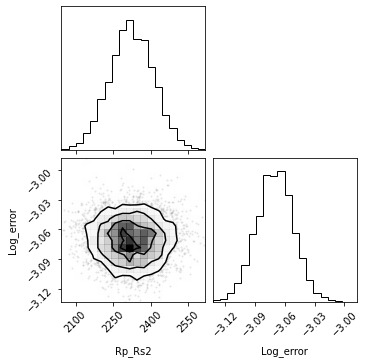

In [33]:
'''
corner plot .81 microns, printing transit depth and error. Visually apprx matches transit above
'''


#transit depth fit, hot jupiter at .81 microns
print(transit_depth)
print(std_dev_transit_depth)

corner(df[['rp_rs2', 'loge']], labels = ['Rp_Rs2', 'Log_error']) # show corner plot
plt.show()

In [34]:
hotjupiter1microns = normalized_hot_jupiter_abs2_3k[0]+1
#transit_depth, std_dev_transit_depth, df = fit_lightcurve(times, hotjupiter1microns)


In [35]:
'''
function to run mcmc on full wavelength range
'''


'''
d = {}
i=0
for n in water_array:
    water_content = str(water_array[i])
    d["data"+water_content] = ascii.read("transmission{0}_hi_res.dat".format(water_content))
    d["data"+water_content+"_pd"] = d["data"+water_content].to_pandas()
    #print(d["data"+water_content+"_pd"])
    i+=1
'''

d_model = {}

def depth_fit(diff_array, exo_type, ref_temp, abs_wave):
    if abs_wave == 1:
        wave_range = wave_range_abs1
        #range_value = 20
    elif abs_wave == 2:
        wave_range = wave_range_abs2
        #range_value = 8
    elif abs_wave == 3:
        wave_range = wave_range_abs3
        #range_value = 8
    else:
        wave_range = wave_range_abs4
        #range_value = 11
        
    if exo_type == "hot_jupiter":
        times = np.linspace(-0.5, 0.5, 540)
    else:
        times = np.linspace(-0.25, 0.25, 540)
    depth_array = []
    std_dev_array = []
    df_array = []
    wavelength_array = []
    
    range_value = len(wave_range)
    
    i=0
    
    #times = 
    for n in range(range_value-1):
        wavelength = wave_range[i]
        
        wave_rounded = np.round(wavelength, 4)
        print(wave_rounded)
        d_model["depth"+str(exo_type)+str(wave_rounded)+str(ref_temp)], d_model["std"+str(exo_type)+str(wave_rounded)+str(ref_temp)], d_model["df"+str(exo_type)+str(wave_rounded)+str(ref_temp)] = fit_lightcurve(times, diff_array[i]+1)
        depth_array.append(d_model["depth"+str(exo_type)+str(wave_rounded)+str(ref_temp)])
        std_dev_array.append(d_model["std"+str(exo_type)+str(wave_rounded)+str(ref_temp)])
        df_array.append(d_model["df"+str(exo_type)+str(wave_rounded)+str(ref_temp)])
        wavelength_array.append(wavelength)
        
        
        i+=1
    
    return depth_array, std_dev_array, df_array, wavelength_array

In [36]:
'''
running depth fit on wave range 1
'''
model_hot_jupiter_abs1_3k = depth_fit(normalized_hot_jupiter_abs1_3k, "hot_jupiter", 3000, 1)

0.6


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.603


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.606


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.609


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.6121


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.6152


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.6182


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.6213


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.6244


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.6275


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.6307


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.6338


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.637


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.6402


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.6434


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.6466


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.6498


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.6531


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.6564


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.6596


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.6629


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.6663


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.6696


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.6729


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.6763


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.6797


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.6831


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.6865


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.6899


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.6934


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.6968


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.7003


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.7038


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.7073


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.7109


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.7144


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.718


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.7216


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.7252


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.7288


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.7325


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.7361


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.7398


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.7435


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.7472


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.751


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.7547


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.7585


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.7623


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.7661


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.7699


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.7738


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.7777


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.7815


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.7855


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.7894


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.7933


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.7973


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.8013


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.8053


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.8093


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.8134


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.8174


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.8215


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.8256


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.8297


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.8339


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.8381


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.8423


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.8465


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.8507


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.855


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.8592


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.8635


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.8678


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.8722


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.8765


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.8809


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.8853


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.8898


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.8942


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.8987


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.9032


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.9077


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.9122


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.9168


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.9214


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.926


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.9306


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.9353


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.9399


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.9446


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.9494


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.9541


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.9589


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.9637


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.9685


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.9733


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.9782


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.9831


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.988


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.9929


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

  col5 
-------
538.053
533.794
529.542
525.298
521.099
517.016
512.995
509.127
 504.41
500.133
    ...
237.697
231.181
 232.46
237.437
245.759
257.201
254.126
259.345
265.445
262.477
272.624
Length = 103 rows


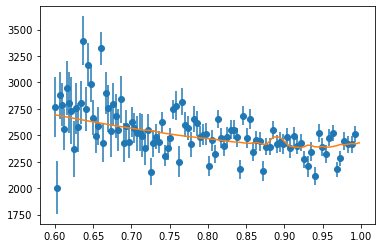

In [37]:
'''
plotting wave range 1
'''

plt.errorbar(model_hot_jupiter_abs1_3k[3], model_hot_jupiter_abs1_3k[0], model_hot_jupiter_abs1_3k[1], ls="none")
plt.scatter(model_hot_jupiter_abs1_3k[3], model_hot_jupiter_abs1_3k[0])

atm_signal1 = hot_jupiter_abs1["col5"]
bulk_transit1 = (0.04644**2)*10**6

#bulk_transit_depth = np.sqrt(bulk_transit)
#print(bulk_transit_depth)
total_depth1 = (atm_signal1+bulk_transit1)
print(atm_signal1)

plt.plot(hot_jupiter_abs1["col1"], total_depth1)

In [38]:
'''
running depth fit on wave range 3
'''
model_hot_jupiter_abs3_3k = depth_fit(normalized_hot_jupiter_abs3_3k, "hot_jupiter", 3000, 3)

1.25


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.2562


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.2625


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.2688


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.2752


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.2816


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.288


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.2944


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.3009


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.3074


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.3139


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.3205


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.3271


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.3337


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.3404


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.3471


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.3538


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.3606


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.3674


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.3742


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.3811


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.388


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.395


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.4019


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.4089


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.416


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.4231


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.4302


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.4373


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.4445


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.4518


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.459


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.4663


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.4736


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.481


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.4884


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.4959


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.5033


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.5108


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.5184


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.526


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.5336


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.5413


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.549


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

  col5 
-------
285.574
297.726
301.974
300.368
  303.7
304.953
310.524
315.631
 324.08
335.374
    ...
522.163
505.779
494.668
479.218
468.512
460.766
455.726
445.314
442.407
437.696
476.882
Length = 45 rows


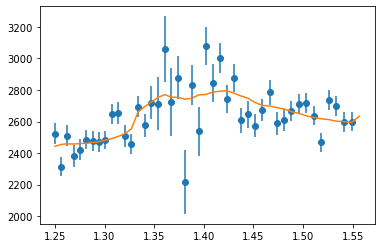

In [39]:
'''
plotting wave range 3
'''

plt.errorbar(model_hot_jupiter_abs3_3k[3], model_hot_jupiter_abs3_3k[0], model_hot_jupiter_abs3_3k[1], ls="none")
plt.scatter(model_hot_jupiter_abs3_3k[3], model_hot_jupiter_abs3_3k[0])

atm_signal = hot_jupiter_abs3["col5"]
bulk_transit = (0.04644**2)*10**6

#bulk_transit_depth = np.sqrt(bulk_transit)
#print(bulk_transit_depth)
total_depth = (atm_signal+bulk_transit)
print(atm_signal)

plt.plot(hot_jupiter_abs3["col1"], total_depth)

In [40]:
'''
running depth fit on wave range 2
'''
model_hot_jupiter_abs2_3k = depth_fit(normalized_hot_jupiter_abs2_3k, "hot_jupiter", 3000, 2)

1


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.005


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.01


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.0151


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.0202


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.0253


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.0304


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.0355


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.0407


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.0459


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.0511


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.0564


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.0617


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.067


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.0723


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.0777


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.0831


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.0885


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.0939


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.0994


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.1049


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.1104


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.116


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.1216


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.1272


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.1328


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.1385


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.1442


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.1499


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.1556


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.1614


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.1672


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.173


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.1789


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.1848


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.1907


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.1967


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.2027


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.2087


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.2147


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.2208


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.2269


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.233


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.2392


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

  col5 
-------
282.985
277.875
271.418
269.097
255.799
 248.06
240.819
233.987
229.383
228.352
    ...
379.144
369.563
362.849
342.918
330.276
326.345
308.172
303.655
291.776
289.186
286.199
Length = 45 rows


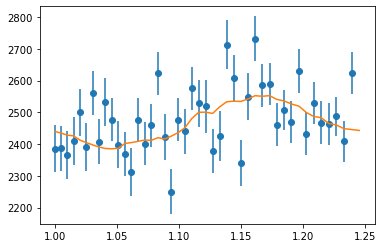

In [41]:
'''
plotting wave range 2
'''


plt.errorbar(model_hot_jupiter_abs2_3k[3], model_hot_jupiter_abs2_3k[0], model_hot_jupiter_abs2_3k[1], ls="none")
plt.scatter(model_hot_jupiter_abs2_3k[3], model_hot_jupiter_abs2_3k[0])

atm_signal2 = hot_jupiter_abs2["col5"]
bulk_transit2 = (0.04644**2)*10**6

#bulk_transit_depth = np.sqrt(bulk_transit)
#print(bulk_transit_depth)
total_depth2 = (atm_signal2+bulk_transit2)
print(atm_signal2)

plt.plot(hot_jupiter_abs2["col1"], total_depth2)

In [42]:
'''
depth fit on wave range 4
'''

model_hot_jupiter_abs4_3k = depth_fit(normalized_hot_jupiter_abs4_3k, "hot_jupiter", 3000, 4)

1.56


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.5678


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.5756


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.5835


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.5914


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.5994


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.6074


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.6154


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.6235


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.6316


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.6398


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.648


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.6562


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.6645


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.6728


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.6812


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.6896


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.698


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.7065


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.7151


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.7236


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.7323


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.7409


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.7496


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.7584


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.7672


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.776


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.7849


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.7938


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.8028


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.8118


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.8208


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.8299


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.8391


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.8483


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.8575


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.8668


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.8762


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.8855


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.895


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.9044


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.914


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.9235


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.9331


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.9428


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.9525


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.9623


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.9721


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.982


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.9919


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

2.0018


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

2.0118


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

2.0219


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

2.032


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

2.0422


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

2.0524


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

2.0626


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

2.073


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

2.0833


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

  col5 
-------
549.959
473.368
486.524
 529.01
515.699
596.408
581.351
 604.33
631.063
612.445
    ...
806.239
879.016
927.865
881.099
1002.58
936.304
969.174
1013.76
975.533
1026.27
984.679
Length = 87 rows


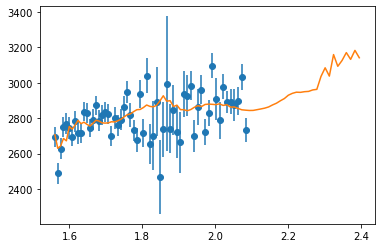

In [43]:
'''
plotting wave range 4. right now, more of simulated spectrum is included than depth fitted spectrum
'''


plt.errorbar(model_hot_jupiter_abs4_3k[3], model_hot_jupiter_abs4_3k[0], model_hot_jupiter_abs4_3k[1], ls="none")
plt.scatter(model_hot_jupiter_abs4_3k[3], model_hot_jupiter_abs4_3k[0])

atm_signal4 = hot_jupiter_abs4["col5"]
bulk_transit4 = (0.04644**2)*10**6

#bulk_transit_depth = np.sqrt(bulk_transit)
#print(bulk_transit_depth)
total_depth4 = (atm_signal4+bulk_transit4)
print(atm_signal4)

plt.plot(hot_jupiter_abs4["col1"], total_depth4)

In [44]:
'''
next step, concatenate together
'''

'\nnext step, concatenate together\n'

In [45]:
'''
concat injected transit depths
'''

hot_jupiter_abs1_injected_transit = hot_jupiter_abs1["col5"][0:-1]
hot_jupiter_abs2_injected_transit = hot_jupiter_abs2["col5"][0:-1]
hot_jupiter_abs3_injected_transit = hot_jupiter_abs3["col5"][0:-1]
hot_jupiter_abs4_injected_transit = hot_jupiter_abs4["col5"][0:59]
hot_jupiter_injected_transit = np.concatenate((hot_jupiter_abs1_injected_transit, hot_jupiter_abs2_injected_transit, hot_jupiter_abs3_injected_transit, hot_jupiter_abs4_injected_transit))

#model_hot_jupiter_abs1_8000 = np.concatenate((model_hot_jupiter_abs1_8000[0], model_hot_jupiter_abs2_8000[0], model_hot_jupiter_abs3_8000[0], model_hot_jupiter_abs4_8000[0]))

#model_hot_jupiter_abs1_8000_wave = np.concatenate((model_hot_jupiter_abs1_8000[3], model_hot_jupiter_abs2_8000[3], model_hot_jupiter_abs3_8000[3], model_hot_jupiter_abs4_8000[3]))

#model_hot_jupiter_abs1_8000_std = np.concatenate((model_hot_jupiter_abs1_8000[1], model_hot_jupiter_abs2_8000[1], model_hot_jupiter_abs3_8000[1], model_hot_jupiter_abs4_8000[1]))




In [46]:
'''
check injected transit depths
'''
hot_jupiter_injected_transit

array([538.053, 533.794, 529.542, 525.298, 521.099, 517.016, 512.995,
       509.127, 504.41 , 500.133, 495.826, 491.575, 487.517, 483.237,
       479.107, 474.99 , 470.824, 466.688, 462.608, 458.476, 454.508,
       450.34 , 446.155, 441.957, 437.802, 433.713, 429.692, 425.58 ,
       421.564, 417.75 , 413.614, 409.807, 406.015, 401.758, 397.675,
       393.926, 392.128, 388.992, 388.158, 385.223, 377.52 , 371.802,
       366.857, 362.447, 358.817, 354.989, 350.855, 346.989, 343.216,
       339.499, 335.692, 332.106, 330.317, 326.564, 323.677, 319.274,
       316.396, 315.216, 310.519, 307.226, 303.358, 300.941, 295.47 ,
       291.556, 287.474, 284.151, 280.867, 279.32 , 276.621, 272.198,
       268.824, 268.128, 270.246, 275.944, 267.849, 258.521, 256.852,
       290.313, 325.426, 329.169, 324.728, 294.402, 261.352, 238.528,
       234.113, 231.136, 227.056, 235.296, 250.866, 246.073, 235.127,
       233.532, 237.697, 231.181, 232.46 , 237.437, 245.759, 257.201,
       254.126, 259.

In [47]:
'''
concat transit depths, wave range, and std dev for fitted mcmc model
'''

model_hot_jupiter_3000 = np.concatenate((model_hot_jupiter_abs1_3k[0], model_hot_jupiter_abs2_3k[0], model_hot_jupiter_abs3_3k[0], model_hot_jupiter_abs4_3k[0]))
model_hot_jupiter_3000_wave = np.concatenate((model_hot_jupiter_abs1_3k[3], model_hot_jupiter_abs2_3k[3], model_hot_jupiter_abs3_3k[3], model_hot_jupiter_abs4_3k[3]))
model_hot_jupiter_3000_std = np.concatenate((model_hot_jupiter_abs1_3k[1], model_hot_jupiter_abs2_3k[1], model_hot_jupiter_abs3_3k[1], model_hot_jupiter_abs4_3k[1]))

In [49]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

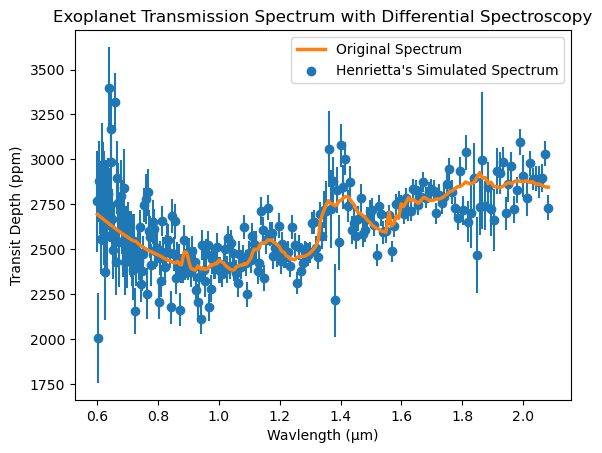

In [50]:
#model_hot_jupiter_abs2_5000
plt.scatter(model_hot_jupiter_3000_wave, model_hot_jupiter_3000, label="Henrietta's Simulated Spectrum")
plt.errorbar(model_hot_jupiter_3000_wave, model_hot_jupiter_3000, model_hot_jupiter_3000_std, ls="none")

atm_signal = hot_jupiter_injected_transit
bulk_transit = (0.04644**2)*10**6

#bulk_transit_depth = np.sqrt(bulk_transit)
#print(bulk_transit_depth)
total_depth = (atm_signal+bulk_transit)
#print(atm_signal)

plt.plot(model_hot_jupiter_3000_wave, total_depth, label="Original Spectrum", linewidth=2.5)
plt.title("Exoplanet Transmission Spectrum with Differential Spectroscopy")
plt.xlabel("Wavlength (μm)")
plt.ylabel("Transit Depth (ppm)")

#ax = plt.gca()
#ax.set_ylim(2000, 10000)



plt.legend()

plt.savefig("../Output/3000KSpectrum_7mag.png")

In [48]:
np.save("../Data/divided_3k_7mag_120secexp.dat", model_hot_jupiter_3000)

In [151]:
((model_hot_jupiter_3000_std/np.mean(model_hot_jupiter_3000))**2)/len(model_hot_jupiter_3000)

array([3.98956582e-05, 3.18533150e-05, 2.25811483e-05, 2.47701229e-05,
       2.12896257e-05, 3.33189316e-05, 5.27684399e-05, 6.43144856e-05,
       4.36346061e-05, 4.03328018e-05, 3.21994084e-05, 3.17515396e-05,
       2.75867110e-05, 2.57622926e-05, 2.46007602e-05, 2.13639386e-05,
       1.97137835e-05, 1.69549522e-05, 1.81352315e-05, 1.99873378e-05,
       2.16711277e-05, 2.92294511e-05, 2.84963762e-05, 3.00578942e-05,
       2.57383047e-05, 2.52678524e-05, 2.40512084e-05, 3.12617535e-05,
       1.89128843e-05, 1.23999017e-05, 1.26959081e-05, 1.33513059e-05,
       1.22135307e-05, 1.66118257e-05, 2.02560517e-05, 1.98058912e-05,
       1.70603168e-05, 1.61730785e-05, 1.22437740e-05, 9.82906750e-06,
       7.73069778e-06, 6.97876414e-06, 6.03431884e-06, 6.18171192e-06,
       5.86222590e-06, 6.42665217e-06, 6.09802838e-06, 1.03808212e-05,
       1.09570582e-05, 1.19942907e-05, 9.08226408e-06, 8.52038393e-06,
       7.15652169e-06, 7.68966149e-06, 6.14385527e-06, 6.67307788e-06,
      

In [70]:
def chi_squared_array(obs, exp):
    diff_array = (obs-exp)**2
    ind_values = diff_array/exp
    stat = np.sum(ind_values)
    return stat
    

In [71]:
chi_squared_array(model_hot_jupiter_3000, total_depth)

1850.5012691214797

In [101]:
def gaussian(mu, sigma, x):
    funct = (1/(sigma*np.sqrt(2*np.pi)))*np.e**(-.5*(((x-mu)/sigma)**2))
    return funct
    

In [123]:
def gaussian_array(obs, exp, std_dev):
    i = 0 
    result_array = []
    for n in obs:
        obs_gauss = gaussian(exp[i], std_dev[i], obs[i])
        exp_gauss = gaussian(exp[i], std_dev[i], exp[i])
        result = (obs_gauss-exp_gauss)**2
        result_array.append(result)
        i+=1
    chi_square = np.sum(result_array)/len(obs)
    #chi_square = np.sum(result_array)
    return chi_square
    #return result_array

In [139]:
def gaussian_array_test2(obs, exp, std_dev):
    i = 0 
    result_array = []
    for n in obs:
        obs_gauss = gaussian(exp[i], std_dev[i], obs[i])
        exp_gauss = gaussian(exp[i], std_dev[i], exp[i])
        result = np.absolute(obs_gauss**2-exp_gauss**2)
        result_array.append(result)
        i+=1
    chi_square = np.sum(result_array)/len(obs)
    #chi_square = np.sum(result_array)
    return chi_square
    #return result_array

In [140]:
chi_square_3k_test2 = gaussian_array_test2(model_hot_jupiter_3000, total_depth, model_hot_jupiter_3000_std)
chi_square_3k_test2

1.2970254209607115e-05

In [124]:
chi_square_3k = gaussian_array(model_hot_jupiter_3000, total_depth, model_hot_jupiter_3000_std)
chi_square_3k

6.618249908315913e-06

In [120]:
#model_hot_jupiter_3000_std

In [52]:
'''
chi-square minimization

using (obs-exp/std_dev)**2. the sum of this gives chi-squared value, dividing by number of samples gives goodness of fit
But not sure how to evaluate this??

https://www.asc.ohio-state.edu/gan.1/teaching/spring04/Chapter6.pdf
https://www.phys.hawaii.edu/~varner/PHYS305-Spr12/DataFitting.html
'''

def chi_min(obs, exp, std_dev):
    chi = ((obs-exp)/std_dev)**2
    return np.sum(chi)/len(obs)
    #return np.sum(chi)

In [54]:
chi_min_3k = chi_min(model_hot_jupiter_3000, total_depth, model_hot_jupiter_3000_std)
#chi_min_7k = chi_min(model_hot_jupiter_7000, total_depth, model_hot_jupiter_7000_std)
print(chi_min_3k)
#print(chi_min_7k)

1.791528518998941


In [136]:
len(total_depth)

249

In [ ]:
'''
mcmc fitting undivided series
'''

In [55]:
'''
running depth fit on wave range 1
'''
model_nodiv_abs1 = depth_fit(normalized_nodiv_abs1, "hot_jupiter", 3000, 1)

0.6


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.603


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.606


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.609


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.6121


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.6152


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.6182


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.6213


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.6244


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.6275


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.6307


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.6338


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.637


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.6402


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.6434


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.6466


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.6498


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.6531


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.6564


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.6596


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.6629


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.6663


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.6696


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.6729


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.6763


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.6797


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.6831


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.6865


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.6899


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.6934


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.6968


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.7003


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.7038


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.7073


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.7109


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.7144


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.718


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.7216


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.7252


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.7288


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.7325


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.7361


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.7398


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.7435


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.7472


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.751


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.7547


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.7585


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.7623


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.7661


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.7699


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.7738


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.7777


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.7815


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.7855


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.7894


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.7933


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.7973


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.8013


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.8053


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.8093


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.8134


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.8174


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.8215


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.8256


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.8297


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.8339


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.8381


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.8423


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.8465


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.8507


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.855


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.8592


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.8635


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.8678


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.8722


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.8765


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.8809


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.8853


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.8898


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.8942


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.8987


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.9032


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.9077


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.9122


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.9168


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.9214


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.926


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.9306


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.9353


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.9399


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.9446


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.9494


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.9541


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.9589


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.9637


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.9685


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.9733


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.9782


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.9831


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.988


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.9929


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

In [56]:
'''
running depth fit on wave range 2
'''
model_nodiv_abs2 = depth_fit(normalized_nodiv_abs2, "hot_jupiter", 3000, 2)

1


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.005


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.01


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.0151


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.0202


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.0253


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.0304


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.0355


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.0407


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.0459


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.0511


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.0564


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.0617


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.067


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.0723


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.0777


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.0831


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.0885


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.0939


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.0994


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.1049


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.1104


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.116


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.1216


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.1272


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:02<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.1328


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.1385


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.1442


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.1499


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.1556


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.1614


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.1672


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.173


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.1789


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.1848


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.1907


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.1967


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.2027


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.2087


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.2147


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.2208


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.2269


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.233


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.2392


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

In [57]:
'''
running depth fit on wave range 3
'''
model_nodiv_abs3 = depth_fit(normalized_nodiv_abs3, "hot_jupiter", 3000, 3)

1.25


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.2562


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.2625


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.2688


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.2752


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.2816


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.288


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.2944


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.3009


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.3074


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.3139


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.3205


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.3271


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.3337


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.3404


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.3471


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.3538


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.3606


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.3674


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.3742


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.3811


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.388


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.395


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.4019


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.4089


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.416


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.4231


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.4302


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.4373


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.4445


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.4518


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.459


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.4663


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.4736


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.481


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.4884


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.4959


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.5033


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.5108


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.5184


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.526


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.5336


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.5413


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.549


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

In [58]:
'''
running depth fit on wave range 4
'''
model_nodiv_abs4 = depth_fit(normalized_nodiv_abs4, "hot_jupiter", 3000, 4)

1.56


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.5678


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.5756


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.5835


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.5914


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.5994


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.6074


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.6154


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.6235


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.6316


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.6398


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.648


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.6562


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.6645


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.6728


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.6812


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.6896


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.698


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.7065


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.7151


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.7236


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.7323


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.7409


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.7496


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.7584


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.7672


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.776


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.7849


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.7938


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.8028


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.8118


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.8208


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.8299


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.8391


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.8483


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.8575


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.8668


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.8762


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.8855


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.895


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.9044


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.914


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.9235


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.9331


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.9428


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.9525


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.9623


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.9721


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.982


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.9919


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

2.0018


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

2.0118


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

2.0219


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

2.032


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

2.0422


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

2.0524


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

2.0626


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

2.073


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

2.0833


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

In [59]:
'''
concat transit depths, wave range, and std dev for fitted mcmc model
'''

model_nodiv = np.concatenate((model_nodiv_abs1[0], model_nodiv_abs2[0], model_nodiv_abs3[0], model_nodiv_abs4[0]))
model_nodiv_wave = np.concatenate((model_nodiv_abs1[3], model_nodiv_abs2[3], model_nodiv_abs3[3], model_nodiv_abs4[3]))
model_nodiv_std = np.concatenate((model_nodiv_abs1[1], model_nodiv_abs2[1], model_nodiv_abs3[1], model_nodiv_abs4[1]))

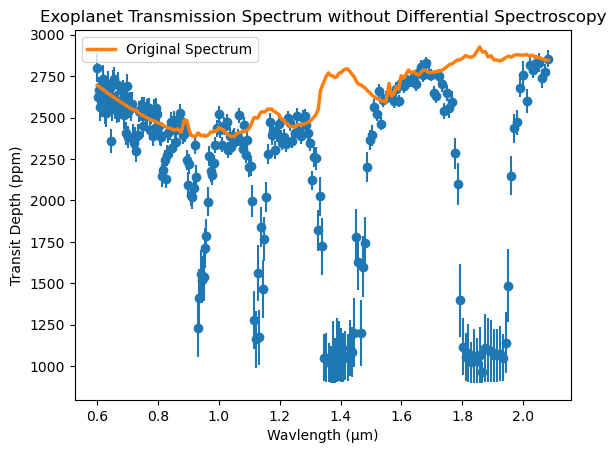

In [60]:
#model_hot_jupiter_abs2_5000
plt.scatter(model_nodiv_wave, model_nodiv, label="")
plt.errorbar(model_nodiv_wave, model_nodiv, model_nodiv_std, ls="none")

atm_signal = hot_jupiter_injected_transit
bulk_transit = (0.04644**2)*10**6

#bulk_transit_depth = np.sqrt(bulk_transit)
#print(bulk_transit_depth)
total_depth = (atm_signal+bulk_transit)
#print(atm_signal)

plt.plot(model_nodiv_wave, total_depth, label="Original Spectrum", linewidth=2.5)
plt.title("Exoplanet Transmission Spectrum without Differential Spectroscopy")
plt.xlabel("Wavlength (μm)")
plt.ylabel("Transit Depth (ppm)")

#ax = plt.gca()
#ax.set_ylim(2000, 10000)



plt.legend()

plt.savefig("../Output/3000KSpectrum_7mag.png")

In [ ]:
'''
trying to reproduce plot with undivided ref and target timeseries and divided timeseries
'''

In [16]:
def diff_spec_v2_pt1_transit(target_temp, ref_temp, mag1, mag2):
    target_spec = spectrum(target_temp, mag1)
    ref_spec = spectrum(ref_temp, mag2)
    return target_spec, ref_spec

def diff_spec_v2_pt2_transit(target_spec, ref_spec, target_pwv, ref_pwv, wave_in, wave_out, atm, res=200, exp_time = 3600, throughput = .4):
    target_binned = binned_flux_pwv_v2(target_spec, target_pwv, wave_in, wave_out, res)
    #wave_array = target_binned_all[1]
    ref_binned = binned_flux_pwv_v2(ref_spec, ref_pwv, wave_in, wave_out, res)
    target_stacked = stacking(target_binned)
    ref_stacked = stacking(ref_binned)
    diff = division_noise_transit(target_stacked, ref_stacked, atm)
    return diff

def diff_spec_v2_pt3_transit(diff):
    normalized_array = []
    i=0
    for n in diff:
        diff_mean = np.mean(diff[i])
        normalized = (diff[i]-diff_mean)/diff_mean
        normalized_array.append(normalized)
        i+=1    
    return normalized_array

In [17]:
def diff_spec_v2_pt1_transit_nodiv(target_temp, ref_temp, mag1, mag2):
    target_spec = spectrum(target_temp, mag1)
    ref_spec = spectrum(ref_temp, mag2)
    return target_spec, ref_spec

def diff_spec_v2_pt2_transit_nodiv(target_spec, ref_spec, target_pwv, ref_pwv, wave_in, wave_out, atm, res=200, exp_time = 3600, throughput = .4):
    target_binned = binned_flux_pwv_v2(target_spec, target_pwv, wave_in, wave_out, res)
    #wave_array = target_binned_all[1]
    ref_binned = binned_flux_pwv_v2(ref_spec, ref_pwv, wave_in, wave_out, res)
    target_stacked = stacking(target_binned)
    ref_stacked = stacking(ref_binned)
    diff = no_division_noise_transit(target_stacked, ref_stacked, atm)
    return diff

def diff_spec_v2_pt3_transit_nodiv(diff):
    normalized_array = []
    i=0
    for n in diff:
        diff_mean = np.mean(diff[i])
        normalized = ((diff[i])/diff_mean)-1
        normalized_array.append(normalized)
        i+=1    
    return normalized_array
    

In [18]:
planet_atm_abs3 = ascii.read("../Data/planet_atm_spec_1.25-1.56.dat")

In [22]:
target_spec_close, ref_spec_close = diff_spec_v2_pt1_transit(4000, 3000, 7, 7)


In [23]:
def no_division_noise_transit(target_array, ref_array, atm):
    target_array_transit = []
    ref_array_notransit = []
    bin_size_array = [target_array[1][1]-target_array[1][0]]
    
    t = np.linspace(-0.5, 0.5, 270)
    bulk_transit_depth = params.rp**2
    #new_array2
    i=0
    for n in target_array[0][0]:
        if i >= len(atm["col6"]):
            break
        
        bin_size = target_array[1][i+1]-target_array[1][i]
        bin_size_array.append(bin_size)
        target_array_i = np.array(target_array[0][:,i])
        #print("original target array"+str(target_array_i[0:10]))
        
        #adding transit
        atm_transit_i = atm["col6"][i]/10**6
        #print("atm depth"+str(atm_transit_i))
        
        total_transit_depth = bulk_transit_depth + atm_transit_i
        rp_i = np.sqrt(total_transit_depth)
        params.rp = rp_i
        #print("rp"+str(params.rp))
        model = batman.TransitModel(params, t)
        transit = model.light_curve(params)
        #print("transit model"+str(transit[500:510]))
        
        #flux = stellar_flux_value*transmission
        transit_flux = transit*target_array_i
        #print("flux with transit"+str(transit_flux[0:10]))
        
        
        ref_array_i = np.array(ref_array[0][:,i])
        target_noise = photon_noise(transit_flux, bin_size)
        ref_noise = photon_noise(ref_array_i, bin_size)
        noisy_target_i = target_noise*transit_flux
        noisy_ref_i = ref_noise*ref_array_i
        #divided_i = noisy_target_i/noisy_ref_i
        #new_array1.append(divided_i)
        target_array_transit.append(noisy_target_i)
        ref_array_notransit.append(noisy_ref_i)
        i+=1
        #if i == 3:
            #break
    return target_array_transit, ref_array_notransit

#cold_star_abs1_test3[:,0]


In [24]:
params = params_hot_jupiter
params_hot_jupiter.rp = 0.04644 
close2 = diff_spec_v2_pt2_transit_nodiv(target_spec_close, ref_spec_close, target_star_pwv, comparison_star_pwv, 1.25, 1.56, planet_atm_abs3)
close3 = diff_spec_v2_pt3_transit_nodiv(close2)

bulk_transit_depth: 0.0021566736
bulk_rp: 0.04644


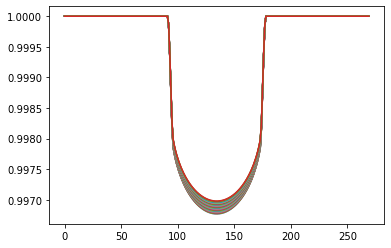

In [25]:
params_hot_jupiter.rp = 0.04644  
divided_for_plot = bin_divide(target_spec_close, ref_spec_close, target_star_pwv, comparison_star_pwv, 1.25, 1.56, hot_jupiter_abs1, params_hot_jupiter)


In [41]:
norm_for_plot = divided_for_plot[20]/np.mean(divided_for_plot[20])

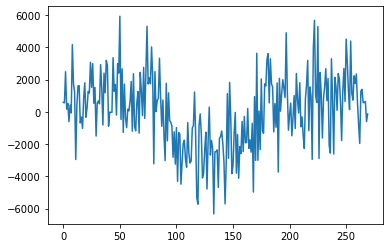

In [46]:
plt.plot((norm_for_plot-1)*10**6)

In [26]:
normalized_for_plot = normalize(divided_for_plot)

/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


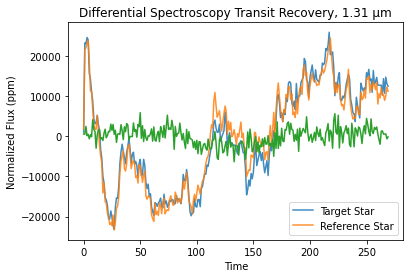

In [47]:
#plt.plot(why_not_divided[4])
#len(why_not_divided)
abs_normalized2 = close2[0][20]/np.mean(close2[0][20])
ref_normalized2 = close2[1][20]/np.mean(close2[1][20])
#len(why_not_divided[0])
plt.plot((abs_normalized2-1)*10**6, label="Target Star", alpha=.85)
plt.plot((ref_normalized2-1)*10**6, label="Reference Star", alpha=.85)
plt.plot((norm_for_plot-1)*10**6)
#plt.plot(normalized_for_plot, label="Divided Signal", color = "black")

#1.381 microns

plt.title("Differential Spectroscopy Transit Recovery, 1.31 μm")
plt.ylabel("Normalized Flux (ppm)")
plt.xlabel("Time")
plt.legend()

#plt.savefig("Diff_Spec.pdf")

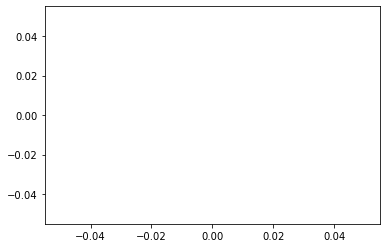

In [30]:
plt.plot(normalized_for_plot[20], label="Divided Signal", color = "black")

In [99]:
np.e

2.718281828459045

In [102]:
gaussian(10, 1, 10)

0.3989422804014327

In [103]:
gaussian(10, 1, 9)

0.24197072451914337

In [104]:
gaussian(10, 1, 11)

0.24197072451914337

In [106]:
((0.3989422804014327-0.24197072451914337)**2)

0.024640069356106683

bulk_transit_depth: 0.0021566736
bulk_rp: 0.04644
bulk_transit_depth: 0.0021566736
bulk_rp: 0.04644
bulk_transit_depth: 0.0021566736
bulk_rp: 0.04644
bulk_transit_depth: 0.0021566736
bulk_rp: 0.04644


'\n#target_binned = binned_flux_pwv_v2(target_spec, target_star_pwv, .6, 1, 200)\n#ref_binned = binned_flux_pwv_v2(ref_spec, comparison_star_pwv, .6, 1, 200)\n\n#target_stacked = stacking(target_binned)\n#ref_stacked = stacking(ref_binned)\n\n\n#divided = division_noise_transit(target_stacked, ref_stacked, hot_jupiter_abs1, params_hot_jupiter)\n'

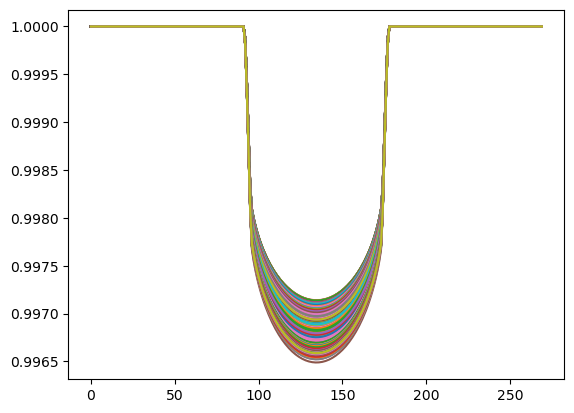

In [72]:
'''
Using target spec 4000K & ref spec 3000K

Binning is taking a really long time to run right now.

Output: binned and divided spectra with transit timeseries at each wavelength bin
'''


params_hot_jupiter.rp = 0.04644  
divided_hot_jupiter_abs1_7k = bin_divide(target_spec, ref_spec_7000, target_star_pwv, comparison_star_pwv, .6, 1, hot_jupiter_abs1, params_hot_jupiter)

params_hot_jupiter.rp = 0.04644
divided_hot_jupiter_abs2_7k = bin_divide(target_spec, ref_spec_7000, target_star_pwv, comparison_star_pwv, 1, 1.25, hot_jupiter_abs2, params_hot_jupiter)
params_hot_jupiter.rp = 0.04644
divided_hot_jupiter_abs3_7k = bin_divide(target_spec, ref_spec_7000, target_star_pwv, comparison_star_pwv, 1.25, 1.56, hot_jupiter_abs3, params_hot_jupiter)
params_hot_jupiter.rp = 0.04644
divided_hot_jupiter_abs4_7k = bin_divide(target_spec, ref_spec_7000, target_star_pwv, comparison_star_pwv, 1.56, 2.1, hot_jupiter_abs4, params_hot_jupiter)
'''
#target_binned = binned_flux_pwv_v2(target_spec, target_star_pwv, .6, 1, 200)
#ref_binned = binned_flux_pwv_v2(ref_spec, comparison_star_pwv, .6, 1, 200)

#target_stacked = stacking(target_binned)
#ref_stacked = stacking(ref_binned)


#divided = division_noise_transit(target_stacked, ref_stacked, hot_jupiter_abs1, params_hot_jupiter)
'''

In [73]:
'''
normalizing transit depth for each abs chunk
'''

normalized_hot_jupiter_abs1_7k = normalize(divided_hot_jupiter_abs1_7k)
normalized_hot_jupiter_abs2_7k = normalize(divided_hot_jupiter_abs2_7k)
normalized_hot_jupiter_abs3_7k = normalize(divided_hot_jupiter_abs3_7k)
normalized_hot_jupiter_abs4_7k = normalize(divided_hot_jupiter_abs4_7k)

1.3811194714834134


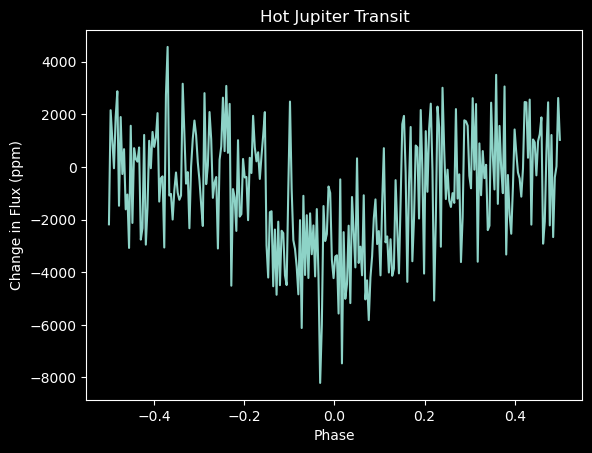

In [75]:
'''
Sample transit timeseries. Depth in ppm, normalized
'''

t = np.linspace(-0.5, 0.5, 270)

plt.style.use('dark_background')

#plt.plot(t, normalized_hot_jupiter_abs4[40]*10**6, label="1.90 μm", color='#1f77b4')
plt.plot(t, normalized_hot_jupiter_abs3_7k[20]*10**6)
#plt.plot(t, normalized_hot_jupiter_abs1[87]*10**6, label=".93 μm", color="orange")



plt.title("Hot Jupiter Transit")
plt.xlabel("Phase")
plt.ylabel("Change in Flux (ppm)")

#plt.legend()
'''
label for wavelength. Should match index and waverange of transit timseries 
'''
print(str(wave_range_abs3[20]))

#plt.savefig("1.9and.93microns.png")
#plt.savefig("1.9microns.png")

In [76]:
'''
installed emcee, corner, will need to update pip soon

error got when I tried to pip install pytransit:
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
anaconda-project 0.9.1 requires ruamel-yaml, which is not installed.
conda-repo-cli 1.0.4 requires pathlib, which is not installed.
spyder 4.2.5 requires pyqt5<5.13, which is not installed.
spyder 4.2.5 requires pyqtwebengine<5.13, which is not installed.
anaconda-client 1.7.2 requires PyYAML>=3.12, but you have pyyaml 3.10 which is incompatible.
asdf 2.15.0 requires pyyaml>=5.4.1, but you have pyyaml 3.10 which is incompatible.
astropy 5.2.1 requires PyYAML>=3.13, but you have pyyaml 3.10 which is incompatible.
conda-repo-cli 1.0.4 requires PyYAML>=3.12, but you have pyyaml 3.10 which is incompatible.

emcee running ok now in Model.ipynb. This sets up corner plots for .81 and .99 microns
'''


%run Model.ipynb

#time = arange(1, 1001, 1)
times = np.linspace(-0.5, 0.5, 270)

#flux = normalized_hot_jupiter_abs1[0]
#transit

hotjupiter_81microns_7k = normalized_hot_jupiter_abs1_7k[60]+1
hotjupiter_99microns_7k = normalized_hot_jupiter_abs1_7k[100]+1

In [88]:


class LPFunction:

    def __init__(self, name: str, times: np.ndarray = None, fluxes: np.ndarray = None, h_model: np.ndarray = np.array([])):

        self.tm = QuadraticModel(klims = (np.sqrt(.1), np.sqrt(.15)), nk = 512, nz = 512)


        # LPF name 
        # ________

        self.name = name

        # Declare high-level objects
        # __________________________

        self.ps = None          # Parameterization
        self.de = None          # Differential evolution optimizer
        self.sampler = None     # MCMC sampler


        # Initialize data
        # _______________

        self.times = np.asarray(times)
        self.fluxes = np.asarray(fluxes)
        #print(self.times)
        #print(times)
        #print(fluxes[0:10])
        #self.time_array = np.linspace(-0.5, 0.5, 1000)
        self.time_array = np.linspace(-0.5, 0.5, 270)
        self.tm.set_data(self.time_array)
        self.params = batman.TransitParams()
        self.params.t0 = 0
        self.params.per = 4.7361 
        self.params.rp = 0 
        self.params.a = 4.98
        self.params.ecc = 0
        self.params.w = 90
        self.params.inc = 90
        self.params.limb_dark = "linear"
        self.params.u = [0.5]
        self.m = batman.TransitModel(self.params, self.time_array, max_err = .02)
        # Define the parameterization
        # ___________________________

        self.ps = ParameterSet([GParameter('rp_rs', 'area_ratio',       'A_s',    UP(0.03, .2), bounds = (0.03, .2)),
                             GParameter('loge', 'log10_error',    '',       UP(-10,-2), bounds = (-10,-2))])
                                #sampling in log space, can do so uniformly

        
        self.ps.freeze()
        #plt.plot(self.time_array, fluxes)
        #plt.show()

        
    def create_pv_population(self, npop = 50):
        return self.ps.sample_from_prior(npop)

    def baseline(self, pv):
        return 1

    def transit_model(self, pv, copy = True):
        pv = np.atleast_2d(pv)
        model = []

        
        for parameter in pv:
            self.params.rp = parameter[0]
            
            model.append(self.m.light_curve(self.params))

        return np.array(model)
        


    def flux_model(self, pv):
        return self.transit_model(pv) * self.baseline(pv)

    def residuals(self, pv):
        return self.fluxes - self.flux_model(pv)

    
    def set_prior(self, pid: int, prior) -> None:
        self.ps[pid].prior = prior

    def lnprior(self, pv):
        return self.ps.lnprior(pv)

    def lnlikelihood(self, pv):
        flux_m = self.flux_model(pv)
        errors = 10**(np.atleast_2d(pv)[:,1])
        
        return lnlike_normal_v(self.fluxes, flux_m, errors)

    def lnposterior(self, pv):
        lnp = self.lnlikelihood(pv) + self.lnprior(pv)
        return np.where(np.isfinite(lnp), lnp, -np.inf)

    def __call__(self, pv):
        return self.lnposterior(pv)

    def optimize(self, niter=200, npop = 500, population = None, label = 'Global optimization', leave = False):
        if self.de is None:
            self.de = DiffEvol(self.lnposterior, np.clip(self.ps.bounds, -1, 1), npop, c = 0.1, maximize = True, vectorize = True)
            if population is None:
                self.de._population[:,:] = self.create_pv_population(npop)
            else:
                self.de._population[:,:] = population

        for _ in tqdm(self.de(niter), total = niter, desc = label, leave = leave):
            pass

    def sample(self, niter = 500, thin = 5, label = 'MCMC sampling', reset = True, leave = True):
        if self.sampler == None:
            self.sampler = EnsembleSampler(self.de.n_pop, self.de.n_par, self.lnposterior, vectorize = True)
            pop0 = self.de.population
            
            #print(self.de.minimum_location)

        else:
            pop0 = self.sampler.chain[:,-1,:].copy()
        if reset:
            self.sampler.reset()
        for _ in tqdm(self.sampler.sample(pop0, iterations = niter, thin = thin), total = niter, desc = label, leave = False):
            pass

    def posterior_samples(self, burn: int = 0, thin: int = 1):
        fc = self.sampler.chain[:, burn::thin, :].reshape([-1, self.de.n_par])
        return pd.DataFrame(fc, columns=self.ps.names)

    def plot_mcmc_chains(self, pid: int=0, alpha: float=0.1, thin: int=1, ax=None):
        fig, ax = (None, ax) if ax is not None else subplots()
        ax.plot(self.sampler.chain[:, ::thin, pid].T, 'k', alpha=alpha)
        fig.tight_layout()
        return fig

    def plot_light_curve(self, model: str = 'de', figsize: tuple = (13, 4)):
        fig, ax = plt.subplots(figsize = figsize, constrained_layout = True)
        cp = sb.color_palette()

        if model == 'de':
            pv = self.de.minimum_location
            
            err = 10**pv[1]
            
        elif model == 'mc':
            fc = np.array(self.posterior_samples())
            pv = np.random.permutation(fc)[:300]
            
            err = 10**np.median(pv[:,1], 0)
            
        ax.errorbar(self.time_array, self.fluxes, err, fmt = '.', c = cp[4], alpha = 0.75)
        #ax.scatter(self.time_array, self.fluxes)
        if model == 'de':
            ax.plot(self.time_array, self.flux_model(pv)[0], c = cp[0])
            pass
        if model == 'mc':
            flux_pr = self.flux_model(fc[np.random.permutation(fc.shape[0])[:1000]])
            flux_pc = np.array(np.percentile(flux_pr, [50, 0.15,99.85, 2.5,97.5, 16,84], 0))
            #[ax.fill_between(self.time_array, *flux_pc[i:i+2,:], alpha=0.2,facecolor=cp[0]) for i in range(1,6,2)]
            ax.plot(self.time_array, flux_pc[0], c=cp[0])
        plt.setp(ax, xlim=self.time_array[[0,-1]], xlabel='Time', ylabel='Normalised flux')
        #plt.ylim((.85, 1.15))
        plt.show()
        return fig, ax







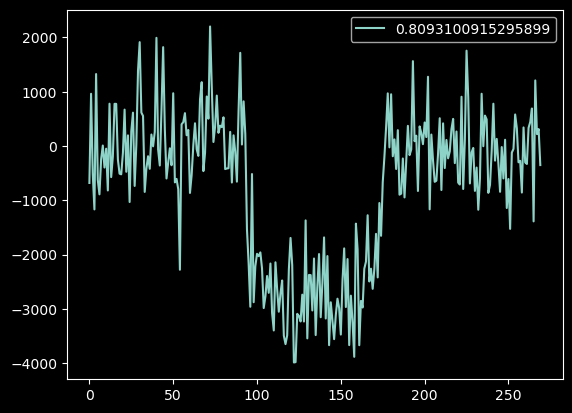

In [89]:
'''
testing transit depth visually at .81 microns
'''

plt.plot(normalized_hot_jupiter_abs1_7k[60]*1000000, label=str(wave_range_abs1[60]))
plt.legend()

In [90]:
'''
mcmc fitting for .81 microns
'''

transit_depth_7k, std_dev_transit_depth_7k, df_7k = fit_lightcurve(times, hotjupiter_81microns_7k)


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

2315.8718127694196
83.31841585021824


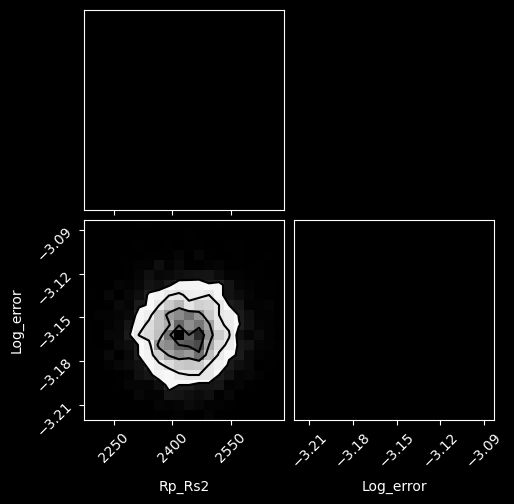

In [91]:
'''
corner plot .81 microns, printing transit depth and error. Visually apprx matches transit above
'''


#transit depth fit, hot jupiter at .81 microns
print(transit_depth)
print(std_dev_transit_depth)

corner(df_7k[['rp_rs2', 'loge']], labels = ['Rp_Rs2', 'Log_error']) # show corner plot
plt.show()

In [92]:
'''
running depth fit on wave range 1
'''
model_hot_jupiter_abs1_7k = depth_fit(normalized_hot_jupiter_abs1_7k, "hot_jupiter", 7000, 1)
model_hot_jupiter_abs2_7k = depth_fit(normalized_hot_jupiter_abs2_7k, "hot_jupiter", 7000, 2)
model_hot_jupiter_abs3_7k = depth_fit(normalized_hot_jupiter_abs3_7k, "hot_jupiter", 7000, 3)
model_hot_jupiter_abs4_7k = depth_fit(normalized_hot_jupiter_abs4_7k, "hot_jupiter", 7000, 4)

0.6


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.603


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.606


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.609


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.6121


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.6152


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.6182


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.6213


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.6244


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.6275


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.6307


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.6338


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.637


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.6402


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.6434


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.6466


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.6498


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.6531


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.6564


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.6596


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.6629


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.6663


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.6696


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.6729


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.6763


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.6797


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.6831


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.6865


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.6899


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.6934


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.6968


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.7003


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.7038


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.7073


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.7109


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.7144


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.718


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.7216


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.7252


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.7288


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.7325


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.7361


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.7398


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.7435


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.7472


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.751


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.7547


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.7585


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.7623


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.7661


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.7699


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.7738


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.7777


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.7815


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.7855


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.7894


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.7933


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.7973


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.8013


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.8053


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.8093


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.8134


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.8174


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.8215


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.8256


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.8297


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.8339


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.8381


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.8423


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.8465


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.8507


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.855


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.8592


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.8635


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.8678


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.8722


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.8765


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.8809


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.8853


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.8898


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.8942


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.8987


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.9032


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.9077


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.9122


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.9168


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.9214


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.926


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.9306


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.9353


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.9399


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.9446


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.9494


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.9541


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.9589


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.9637


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.9685


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.9733


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.9782


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.9831


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.988


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

0.9929


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.005


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.01


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.0151


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.0202


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.0253


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.0304


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.0355


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.0407


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.0459


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.0511


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.0564


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.0617


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.067


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.0723


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.0777


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.0831


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.0885


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.0939


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.0994


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.1049


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.1104


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.116


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.1216


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.1272


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.1328


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.1385


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.1442


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.1499


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.1556


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.1614


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.1672


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.173


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.1789


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.1848


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.1907


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.1967


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.2027


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.2087


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.2147


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.2208


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.2269


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.233


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.2392


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.25


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.2562


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.2625


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.2688


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.2752


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.2816


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.288


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.2944


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.3009


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.3074


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.3139


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.3205


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.3271


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.3337


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.3404


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.3471


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.3538


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.3606


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.3674


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.3742


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.3811


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.388


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.395


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:04<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.4019


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.4089


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.416


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.4231


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.4302


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.4373


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.4445


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.4518


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.459


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.4663


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.4736


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.481


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.4884


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.4959


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.5033


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.5108


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.5184


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.526


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.5336


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.5413


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.549


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.56


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.5678


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.5756


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.5835


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.5914


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.5994


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.6074


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.6154


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.6235


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.6316


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.6398


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.648


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.6562


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.6645


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.6728


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.6812


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.6896


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.698


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.7065


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.7151


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.7236


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.7323


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.7409


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.7496


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.7584


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.7672


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.776


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.7849


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.7938


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.8028


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.8118


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.8208


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.8299


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.8391


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.8483


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.8575


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.8668


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.8762


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.8855


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.895


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.9044


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.914


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.9235


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.9331


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.9428


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.9525


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.9623


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.9721


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.982


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

1.9919


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

2.0018


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

2.0118


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

2.0219


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

2.032


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

2.0422


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

2.0524


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

2.0626


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

2.073


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

2.0833


Global optimization:   0%|          | 0/200 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

  col5 
-------
538.053
533.794
529.542
525.298
521.099
517.016
512.995
509.127
 504.41
500.133
    ...
237.697
231.181
 232.46
237.437
245.759
257.201
254.126
259.345
265.445
262.477
272.624
Length = 103 rows


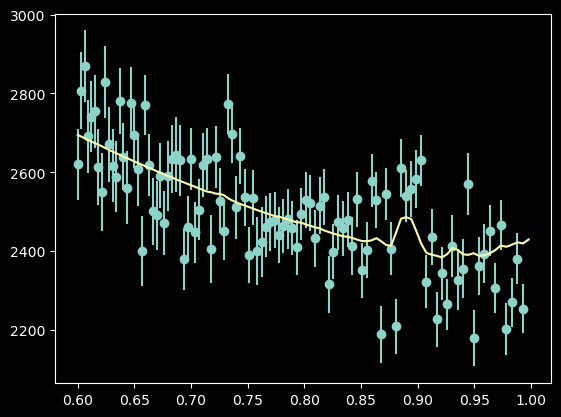

  col5 
-------
282.985
277.875
271.418
269.097
255.799
 248.06
240.819
233.987
229.383
228.352
    ...
379.144
369.563
362.849
342.918
330.276
326.345
308.172
303.655
291.776
289.186
286.199
Length = 45 rows


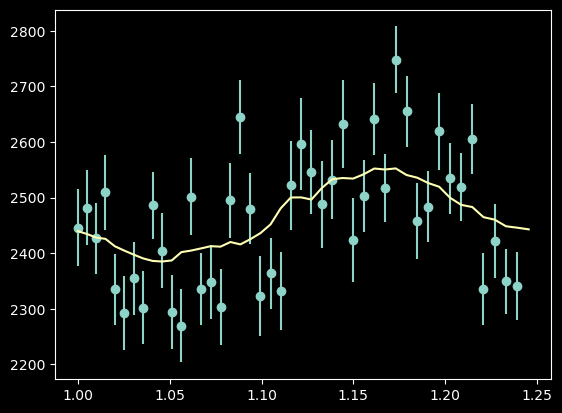

  col5 
-------
285.574
297.726
301.974
300.368
  303.7
304.953
310.524
315.631
 324.08
335.374
    ...
522.163
505.779
494.668
479.218
468.512
460.766
455.726
445.314
442.407
437.696
476.882
Length = 45 rows


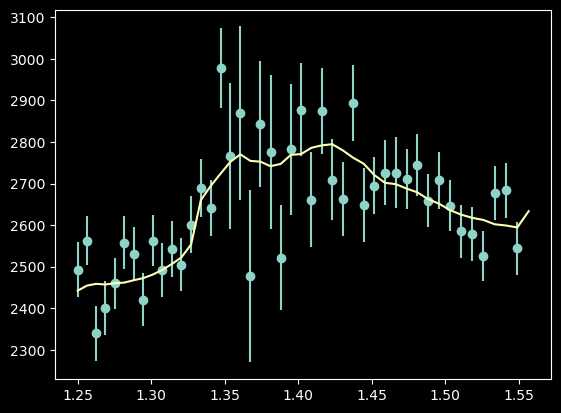

  col5 
-------
549.959
473.368
486.524
 529.01
515.699
596.408
581.351
 604.33
631.063
612.445
    ...
806.239
879.016
927.865
881.099
1002.58
936.304
969.174
1013.76
975.533
1026.27
984.679
Length = 87 rows


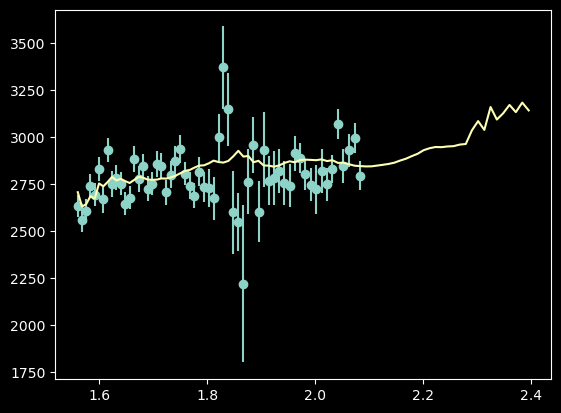

In [93]:
'''
plotting wave range 1
'''

plt.errorbar(model_hot_jupiter_abs1_7k[3], model_hot_jupiter_abs1_7k[0], model_hot_jupiter_abs1_7k[1], ls="none")
plt.scatter(model_hot_jupiter_abs1_7k[3], model_hot_jupiter_abs1_7k[0])

atm_signal1 = hot_jupiter_abs1["col5"]
bulk_transit1 = (0.04644**2)*10**6

#bulk_transit_depth = np.sqrt(bulk_transit)
#print(bulk_transit_depth)
total_depth1 = (atm_signal1+bulk_transit1)
print(atm_signal1)

plt.plot(hot_jupiter_abs1["col1"], total_depth1)

plt.show()

'''
plotting wave range 2
'''


plt.errorbar(model_hot_jupiter_abs2_7k[3], model_hot_jupiter_abs2_7k[0], model_hot_jupiter_abs2_7k[1], ls="none")
plt.scatter(model_hot_jupiter_abs2_7k[3], model_hot_jupiter_abs2_7k[0])

atm_signal2 = hot_jupiter_abs2["col5"]
bulk_transit2 = (0.04644**2)*10**6

#bulk_transit_depth = np.sqrt(bulk_transit)
#print(bulk_transit_depth)
total_depth2 = (atm_signal2+bulk_transit2)
print(atm_signal2)

plt.plot(hot_jupiter_abs2["col1"], total_depth2)

plt.show()

'''
plotting wave range 3
'''

plt.errorbar(model_hot_jupiter_abs3_7k[3], model_hot_jupiter_abs3_7k[0], model_hot_jupiter_abs3_7k[1], ls="none")
plt.scatter(model_hot_jupiter_abs3_7k[3], model_hot_jupiter_abs3_7k[0])

atm_signal = hot_jupiter_abs3["col5"]
bulk_transit = (0.04644**2)*10**6

#bulk_transit_depth = np.sqrt(bulk_transit)
#print(bulk_transit_depth)
total_depth = (atm_signal+bulk_transit)
print(atm_signal)

plt.plot(hot_jupiter_abs3["col1"], total_depth)

plt.show()

'''
plotting wave range 4. right now, more of simulated spectrum is included than depth fitted spectrum
'''

plt.errorbar(model_hot_jupiter_abs4_7k[3], model_hot_jupiter_abs4_7k[0], model_hot_jupiter_abs4_7k[1], ls="none")
plt.scatter(model_hot_jupiter_abs4_7k[3], model_hot_jupiter_abs4_7k[0])

atm_signal4 = hot_jupiter_abs4["col5"]
bulk_transit4 = (0.04644**2)*10**6

#bulk_transit_depth = np.sqrt(bulk_transit)
#print(bulk_transit_depth)
total_depth4 = (atm_signal4+bulk_transit4)
print(atm_signal4)

plt.plot(hot_jupiter_abs4["col1"], total_depth4)

plt.show()

In [94]:
'''
concat transit depths, wave range, and std dev for fitted mcmc model
'''

model_hot_jupiter_7000 = np.concatenate((model_hot_jupiter_abs1_7k[0], model_hot_jupiter_abs2_7k[0], model_hot_jupiter_abs3_7k[0], model_hot_jupiter_abs4_7k[0]))
model_hot_jupiter_7000_wave = np.concatenate((model_hot_jupiter_abs1_7k[3], model_hot_jupiter_abs2_7k[3], model_hot_jupiter_abs3_7k[3], model_hot_jupiter_abs4_7k[3]))
model_hot_jupiter_7000_std = np.concatenate((model_hot_jupiter_abs1_7k[1], model_hot_jupiter_abs2_7k[1], model_hot_jupiter_abs3_7k[1], model_hot_jupiter_abs4_7k[1]))

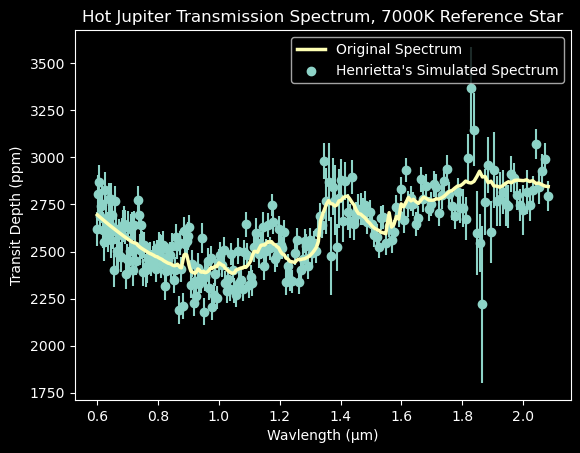

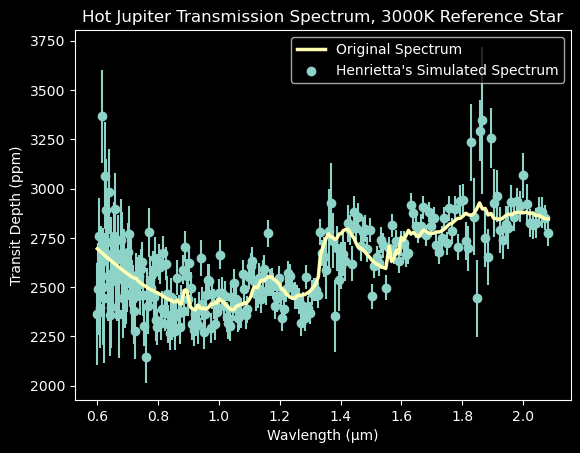

In [95]:
#model_hot_jupiter_abs2_5000
plt.scatter(model_hot_jupiter_7000_wave, model_hot_jupiter_7000, label="Henrietta's Simulated Spectrum")
plt.errorbar(model_hot_jupiter_7000_wave, model_hot_jupiter_7000, model_hot_jupiter_7000_std, ls="none")

atm_signal = hot_jupiter_injected_transit
bulk_transit = (0.04644**2)*10**6

#bulk_transit_depth = np.sqrt(bulk_transit)
#print(bulk_transit_depth)
total_depth = (atm_signal+bulk_transit)
#print(atm_signal)

plt.plot(model_hot_jupiter_7000_wave, total_depth, label="Original Spectrum", linewidth=2.5)
plt.title("Hot Jupiter Transmission Spectrum, 7000K Reference Star")
plt.xlabel("Wavlength (μm)")
plt.ylabel("Transit Depth (ppm)")

#ax = plt.gca()
#ax.set_ylim(2000, 10000)



plt.legend()

plt.show()

#plt.savefig("3000KSpectrum")

#model_hot_jupiter_abs2_5000
plt.scatter(model_hot_jupiter_3000_wave, model_hot_jupiter_3000, label="Henrietta's Simulated Spectrum")
plt.errorbar(model_hot_jupiter_3000_wave, model_hot_jupiter_3000, model_hot_jupiter_3000_std, ls="none")

atm_signal = hot_jupiter_injected_transit
bulk_transit = (0.04644**2)*10**6

#bulk_transit_depth = np.sqrt(bulk_transit)
#print(bulk_transit_depth)
total_depth = (atm_signal+bulk_transit)
#print(atm_signal)

plt.plot(model_hot_jupiter_3000_wave, total_depth, label="Original Spectrum", linewidth=2.5)
plt.title("Hot Jupiter Transmission Spectrum, 3000K Reference Star")
plt.xlabel("Wavlength (μm)")
plt.ylabel("Transit Depth (ppm)")

#ax = plt.gca()
#ax.set_ylim(2000, 10000)



plt.legend()

#plt.savefig("3000KSpectrum")

In [84]:
import scipy

In [96]:
np.save("../Data/divided_3kref_7mag_120secexp.dat", model_hot_jupiter_3000)
np.save("../Data/divided_7kref_7mag_120secexp.dat", model_hot_jupiter_7000)

In [97]:
chi_squared_array(model_hot_jupiter_7000, total_depth)

1284.91134154158

In [98]:
chi_squared_array(model_hot_jupiter_3000, total_depth)

1850.5012691214797

In [126]:
'''
running for 5k
'''

'\nrunning for 5k\n'

In [87]:
'''
Using target spec 4000K & ref spec 3000K

Binning is taking a really long time to run right now.

Output: binned and divided spectra with transit timeseries at each wavelength bin
'''


params_hot_jupiter.rp = 0.04644  
divided_hot_jupiter_abs1_5k = bin_divide(target_spec, ref_spec_5000, target_star_pwv, comparison_star_pwv, .6, 1, hot_jupiter_abs1, params_hot_jupiter)

params_hot_jupiter.rp = 0.04644
divided_hot_jupiter_abs2_5k = bin_divide(target_spec, ref_spec_5000, target_star_pwv, comparison_star_pwv, 1, 1.25, hot_jupiter_abs2, params_hot_jupiter)
params_hot_jupiter.rp = 0.04644
divided_hot_jupiter_abs3_5k = bin_divide(target_spec, ref_spec_5000, target_star_pwv, comparison_star_pwv, 1.25, 1.56, hot_jupiter_abs3, params_hot_jupiter)
params_hot_jupiter.rp = 0.04644
divided_hot_jupiter_abs4_5k = bin_divide(target_spec, ref_spec_5000, target_star_pwv, comparison_star_pwv, 1.56, 2.1, hot_jupiter_abs4, params_hot_jupiter)
'''
#target_binned = binned_flux_pwv_v2(target_spec, target_star_pwv, .6, 1, 200)
#ref_binned = binned_flux_pwv_v2(ref_spec, comparison_star_pwv, .6, 1, 200)

#target_stacked = stacking(target_binned)
#ref_stacked = stacking(ref_binned)


#divided = division_noise_transit(target_stacked, ref_stacked, hot_jupiter_abs1, params_hot_jupiter)
'''

KeyboardInterrupt: 

In [ ]:
'''
normalizing transit depth for each abs chunk
'''

normalized_hot_jupiter_abs1_5k = normalize(divided_hot_jupiter_abs1_5k)
normalized_hot_jupiter_abs2_5k = normalize(divided_hot_jupiter_abs2_5k)
normalized_hot_jupiter_abs3_5k = normalize(divided_hot_jupiter_abs3_5k)
normalized_hot_jupiter_abs4_5k = normalize(divided_hot_jupiter_abs4_5k)

In [ ]:
'''
Sample transit timeseries. Depth in ppm, normalized
'''

t = np.linspace(-0.5, 0.5, 540)

plt.style.use('dark_background')

#plt.plot(t, normalized_hot_jupiter_abs4[40]*10**6, label="1.90 μm", color='#1f77b4')
plt.plot(t, normalized_hot_jupiter_abs3_5k[20]*10**6)
#plt.plot(t, normalized_hot_jupiter_abs1[87]*10**6, label=".93 μm", color="orange")



plt.title("Hot Jupiter Transit")
plt.xlabel("Phase")
plt.ylabel("Change in Flux (ppm)")

#plt.legend()
'''
label for wavelength. Should match index and waverange of transit timseries 
'''
print(str(wave_range_abs3[20]))

#plt.savefig("1.9and.93microns.png")
#plt.savefig("1.9microns.png")

In [ ]:
'''
installed emcee, corner, will need to update pip soon

error got when I tried to pip install pytransit:
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
anaconda-project 0.9.1 requires ruamel-yaml, which is not installed.
conda-repo-cli 1.0.4 requires pathlib, which is not installed.
spyder 4.2.5 requires pyqt5<5.13, which is not installed.
spyder 4.2.5 requires pyqtwebengine<5.13, which is not installed.
anaconda-client 1.7.2 requires PyYAML>=3.12, but you have pyyaml 3.10 which is incompatible.
asdf 2.15.0 requires pyyaml>=5.4.1, but you have pyyaml 3.10 which is incompatible.
astropy 5.2.1 requires PyYAML>=3.13, but you have pyyaml 3.10 which is incompatible.
conda-repo-cli 1.0.4 requires PyYAML>=3.12, but you have pyyaml 3.10 which is incompatible.

emcee running ok now in Model.ipynb. This sets up corner plots for .81 and .99 microns
'''


%run Model.ipynb

#time = arange(1, 1001, 1)
times = np.linspace(-0.5, 0.5, 540)

#flux = normalized_hot_jupiter_abs1[0]
#transit

hotjupiter_81microns_5k = normalized_hot_jupiter_abs1_5k[60]+1
hotjupiter_99microns_5k = normalized_hot_jupiter_abs1_5k[100]+1

In [ ]:
'''
testing transit depth visually at .81 microns
'''

plt.plot(normalized_hot_jupiter_abs1_5k[60]*1000000, label=str(wave_range_abs1[60]))
plt.legend()

In [ ]:
'''
mcmc fitting for .81 microns
'''

transit_depth_5k, std_dev_transit_depth_5k, df_5k = fit_lightcurve(times, hotjupiter_81microns_5k)


In [ ]:
'''
corner plot .81 microns, printing transit depth and error. Visually apprx matches transit above
'''


#transit depth fit, hot jupiter at .81 microns
print(transit_depth)
print(std_dev_transit_depth)

corner(df_5k[['rp_rs2', 'loge']], labels = ['Rp_Rs2', 'Log_error']) # show corner plot
plt.show()

In [ ]:
'''
plotting wave range 1
'''

plt.errorbar(model_hot_jupiter_abs1_5k[3], model_hot_jupiter_abs1_5k[0], model_hot_jupiter_abs1_5k[1], ls="none")
plt.scatter(model_hot_jupiter_abs1_5k[3], model_hot_jupiter_abs1_5k[0])

atm_signal1 = hot_jupiter_abs1["col5"]
bulk_transit1 = (0.04644**2)*10**6

#bulk_transit_depth = np.sqrt(bulk_transit)
#print(bulk_transit_depth)
total_depth1 = (atm_signal1+bulk_transit1)
print(atm_signal1)

plt.plot(hot_jupiter_abs1["col1"], total_depth1)

plt.show()

'''
plotting wave range 2
'''


plt.errorbar(model_hot_jupiter_abs2_5k[3], model_hot_jupiter_abs2_5k[0], model_hot_jupiter_abs2_5k[1], ls="none")
plt.scatter(model_hot_jupiter_abs2_5k[3], model_hot_jupiter_abs2_5k[0])

atm_signal2 = hot_jupiter_abs2["col5"]
bulk_transit2 = (0.04644**2)*10**6

#bulk_transit_depth = np.sqrt(bulk_transit)
#print(bulk_transit_depth)
total_depth2 = (atm_signal2+bulk_transit2)
print(atm_signal2)

plt.plot(hot_jupiter_abs2["col1"], total_depth2)

plt.show()

'''
plotting wave range 3
'''

plt.errorbar(model_hot_jupiter_abs3_5k[3], model_hot_jupiter_abs3_5k[0], model_hot_jupiter_abs3_5k[1], ls="none")
plt.scatter(model_hot_jupiter_abs3_5k[3], model_hot_jupiter_abs3_5k[0])

atm_signal = hot_jupiter_abs3["col5"]
bulk_transit = (0.04644**2)*10**6

#bulk_transit_depth = np.sqrt(bulk_transit)
#print(bulk_transit_depth)
total_depth = (atm_signal+bulk_transit)
print(atm_signal)

plt.plot(hot_jupiter_abs3["col1"], total_depth)

plt.show()

'''
plotting wave range 4. right now, more of simulated spectrum is included than depth fitted spectrum
'''

plt.errorbar(model_hot_jupiter_abs4_5k[3], model_hot_jupiter_abs4_5k[0], model_hot_jupiter_abs4_5k[1], ls="none")
plt.scatter(model_hot_jupiter_abs4_5k[3], model_hot_jupiter_abs4_5k[0])

atm_signal4 = hot_jupiter_abs4["col5"]
bulk_transit4 = (0.04644**2)*10**6

#bulk_transit_depth = np.sqrt(bulk_transit)
#print(bulk_transit_depth)
total_depth4 = (atm_signal4+bulk_transit4)
print(atm_signal4)

plt.plot(hot_jupiter_abs4["col1"], total_depth4)

plt.show()

In [ ]:
'''
concat transit depths, wave range, and std dev for fitted mcmc model
'''

model_hot_jupiter_5000 = np.concatenate((model_hot_jupiter_abs1_5k[0], model_hot_jupiter_abs2_5k[0], model_hot_jupiter_abs3_5k[0], model_hot_jupiter_abs4_5k[0]))
model_hot_jupiter_5000_wave = np.concatenate((model_hot_jupiter_abs1_5k[3], model_hot_jupiter_abs2_5k[3], model_hot_jupiter_abs3_5k[3], model_hot_jupiter_abs4_5k[3]))
model_hot_jupiter_5000_std = np.concatenate((model_hot_jupiter_abs1_5k[1], model_hot_jupiter_abs2_5k[1], model_hot_jupiter_abs3_5k[1], model_hot_jupiter_abs4_5k[1]))

In [ ]:
#model_hot_jupiter_abs2_5000
plt.scatter(model_hot_jupiter_5000_wave, model_hot_jupiter_5000, label="Henrietta's Simulated Spectrum")
plt.errorbar(model_hot_jupiter_5000_wave, model_hot_jupiter_5000, model_hot_jupiter_5000_std, ls="none")

atm_signal = hot_jupiter_injected_transit
bulk_transit = (0.04644**2)*10**6

#bulk_transit_depth = np.sqrt(bulk_transit)
#print(bulk_transit_depth)
total_depth = (atm_signal+bulk_transit)
#print(atm_signal)

plt.plot(model_hot_jupiter_7000_wave, total_depth, label="Original Spectrum", linewidth=2.5)
plt.title("Hot Jupiter Transmission Spectrum, 5000K Reference Star")
plt.xlabel("Wavlength (μm)")
plt.ylabel("Transit Depth (ppm)")

#ax = plt.gca()
#ax.set_ylim(2000, 10000)



plt.legend()

#plt.savefig("3000KSpectrum")